In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [2]:
df = pd.read_json("tlip_like_consignments_5000.jsonl", lines=True)
df.head(5)

,consignment_id,created_at,origin_country,destination_country,origin_port,destination_port,shipment_mode,commodity,hs_code,gross_weight_kg,...,customs_release_hours,terminal_dwell_hours,sla_hours,total_processing_hours,delayed_flag,delay_hours,bl_or_awb_no,container_no,documents,events
0,TLIP-SYN-000001,2025-02-21 09:38:50,RW,ES,Kigali,Madrid,AIR,Mangoes,804,7636.85,...,42.65,37.66,48,80.32,1,4.32,802-78096246,,"[{'consignment_id': 'TLIP-SYN-000001', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000001', 'event'..."
1,TLIP-SYN-000002,2025-01-13 05:46:46,RW,IT,Kigali,Genoa,AIR,Fresh Beans,708,21069.24,...,50.00,25.19,48,75.19,0,0.00,148-27192561,,"[{'consignment_id': 'TLIP-SYN-000002', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000002', 'event'..."
2,TLIP-SYN-000003,2025-09-19 04:40:34,TZ,NL,Dar es Salaam,Rotterdam,AIR,Cut Flowers,603,15769.06,...,31.82,29.51,48,61.34,0,0.00,252-21633769,,"[{'consignment_id': 'TLIP-SYN-000003', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000003', 'event'..."
3,TLIP-SYN-000004,2025-12-04 07:26:32,RW,DE,Kigali,Frankfurt,AIR,Cut Flowers,603,21497.58,...,46.19,38.15,48,84.34,1,8.34,901-77635129,,"[{'consignment_id': 'TLIP-SYN-000004', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000004', 'event'..."
4,TLIP-SYN-000005,2025-05-08 16:09:41,ET,FR,Addis Ababa-ADD,Paris-CDG,SEA,Pineapples,804,21298.46,...,58.94,85.32,96,144.26,1,20.26,BL823732870,XCDZ0728567,"[{'consignment_id': 'TLIP-SYN-000005', 'doc_ty...","[{'consignment_id': 'TLIP-SYN-000005', 'event'..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   consignment_id          5000 non-null   object        
 1   created_at              5000 non-null   datetime64[ns]
 2   origin_country          5000 non-null   object        
 3   destination_country     5000 non-null   object        
 4   origin_port             5000 non-null   object        
 5   destination_port        5000 non-null   object        
 6   shipment_mode           5000 non-null   object        
 7   commodity               5000 non-null   object        
 8   hs_code                 5000 non-null   int64         
 9   gross_weight_kg         5000 non-null   float64       
 10  declared_value_usd      5000 non-null   float64       
 11  exporter_profile        5000 non-null   object        
 12  doc_completeness_score  5000 non-null   float64 

In [4]:
df.describe()


,hs_code,gross_weight_kg,declared_value_usd,doc_completeness_score,missing_docs_proxy,doc_amendments,congestion_index,is_weekend_created,customs_release_hours,terminal_dwell_hours,sla_hours,total_processing_hours,delayed_flag,delay_hours
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,818.200800,17355.272310,47651.335412,0.912280,0.779000,0.569000,0.431820,0.278200,47.146678,51.454264,70.526400,98.600904,0.483800,8.537048
std,170.777984,7696.399211,27312.612578,0.058187,0.613705,0.764824,0.215877,0.448157,14.290495,22.939310,23.677733,34.580239,0.499787,12.833571
min,603.000000,2000.000000,1600.000000,0.713000,0.000000,0.000000,0.000000,0.000000,6.000000,6.000000,48.000000,18.860000,0.000000,0.000000
25%,708.000000,12100.437500,27729.320000,0.870000,0.000000,0.000000,0.261000,0.000000,36.717500,32.787500,48.000000,70.760000,0.000000,0.000000
50%,804.000000,16929.755000,43391.385000,0.914000,1.000000,0.000000,0.414500,0.000000,46.925000,49.210000,48.000000,96.800000,0.000000,0.000000
75%,902.000000,22064.062500,62551.820000,0.959000,1.000000,1.000000,0.587000,1.000000,57.370000,70.062500,96.000000,124.980000,1.000000,14.292500
max,1211.000000,51578.540000,224526.420000,1.000000,3.000000,5.000000,1.000000,1.000000,94.430000,127.540000,96.000000,201.060000,1.000000,77.060000


In [5]:
# Check for duplicate rows (exclude list-like/unhashable columns)
# These columns are likely lists/dicts per the data dictionary and cannot be hashed
hashable_cols = [c for c in df.columns if c not in ["documents", "events"]]

print(f"Number of duplicate rows (on hashable columns): {df.duplicated(subset=hashable_cols).sum()}")
print(f"\nTotal duplicate rows (including first occurrence, on hashable columns): {df.duplicated(subset=hashable_cols, keep=False).sum()}")

df[df.duplicated(subset=hashable_cols, keep=False)]

Number of duplicate rows (on hashable columns): 0

Total duplicate rows (including first occurrence, on hashable columns): 0


,consignment_id,created_at,origin_country,destination_country,origin_port,destination_port,shipment_mode,commodity,hs_code,gross_weight_kg,...,customs_release_hours,terminal_dwell_hours,sla_hours,total_processing_hours,delayed_flag,delay_hours,bl_or_awb_no,container_no,documents,events


In [6]:
# Count unique values, ignoring unhashable list-like columns

unique_counts = df[hashable_cols].nunique()
unique_counts

consignment_id            5000
created_at                4999
origin_country               5
destination_country          7
origin_port                  8
destination_port            14
shipment_mode                2
commodity                    8
hs_code                      6
gross_weight_kg           4888
declared_value_usd        4998
exporter_profile             3
doc_completeness_score     250
missing_docs_proxy           4
doc_amendments               6
congestion_index           910
is_weekend_created           2
customs_release_hours     3236
terminal_dwell_hours      3740
sla_hours                    3
total_processing_hours    4159
delayed_flag                 2
delay_hours               1860
bl_or_awb_no              5000
container_no              2309
dtype: int64

<Axes: xlabel='shipment_mode'>

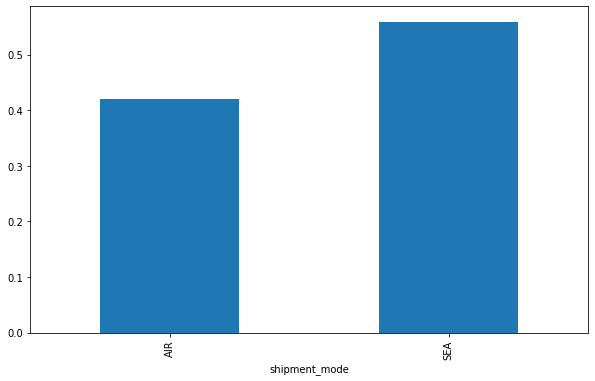

In [7]:
#Check delayed consignments per shipment mode and plot

# Group by shipment mode and calculate delayed consignments
delayed_consignments = df.groupby('shipment_mode')['delayed_flag'].mean()

# Plot the results
delayed_consignments.plot(kind='bar', figsize=(10, 6))

<Axes: xlabel='origin_country'>

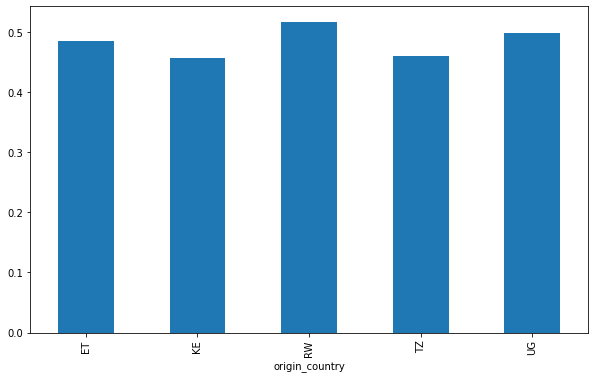

In [8]:
#Chack delayed consignments per origin and plot

# Group by origin and calculate delayed consignments
delayed_consignments_origin = df.groupby('origin_country')['delayed_flag'].mean()

# Plot the results
delayed_consignments_origin.plot(kind='bar', figsize=(10, 6))

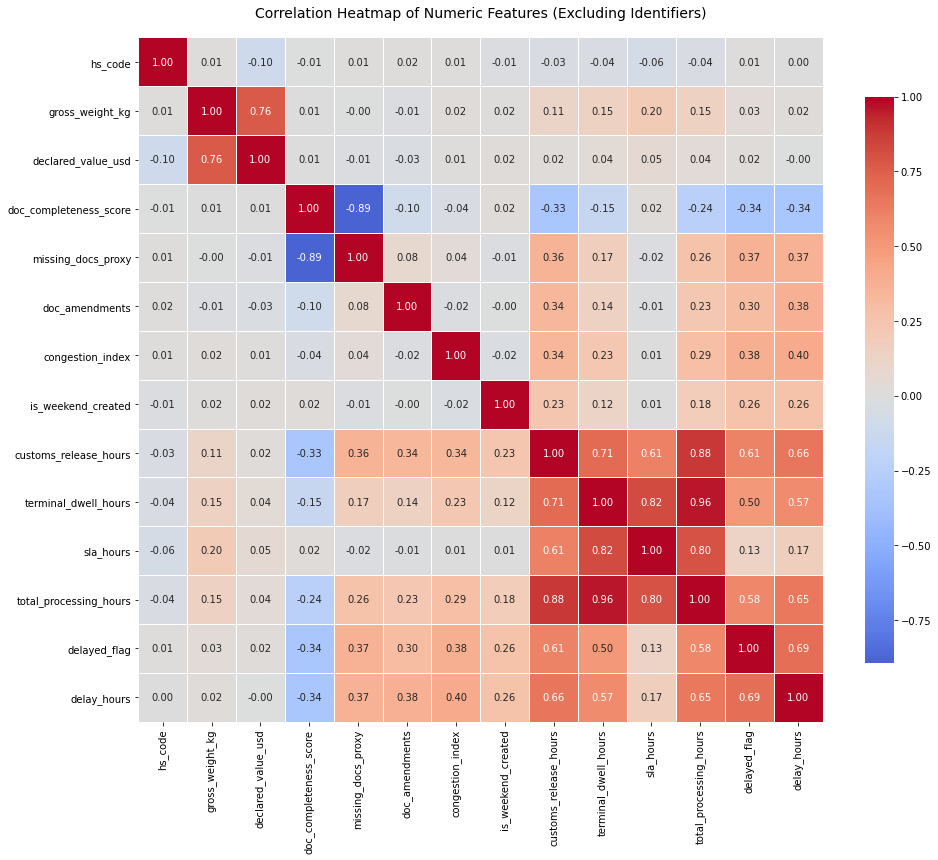

In [9]:
# Check for correlation between delayed consignments and all other features
# Remove identifiers and non-numeric columns

# Identify columns to exclude (identifiers and non-numeric)
identifiers = ['consignment_id', 'bl_or_awb_no', 'container_no', 'documents', 'events']
non_numeric = ['created_at', 'origin_country', 'destination_country', 'origin_port', 
               'destination_port', 'shipment_mode', 'commodity', 'exporter_profile']

# Select only numeric columns (excluding identifiers)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in identifiers]

# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numeric Features (Excluding Identifiers)', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()


# Descriptive Analytics - Pre-Modeling Analysis

This section provides comprehensive descriptive analytics following a structured plan to understand delay patterns before building predictive models.


## 1. Overall Delay Landscape (Baseline Sanity Check)


In [10]:
# Overall delay rate
total_consignments = len(df)
delayed_count = df['delayed_flag'].sum()
delay_rate = (delayed_count / total_consignments) * 100

print("=" * 60)
print("OVERALL DELAY LANDSCAPE")
print("=" * 60)
print(f"Total Consignments: {total_consignments:,}")
print(f"Delayed Consignments: {delayed_count:,}")
print(f"Not Delayed: {total_consignments - delayed_count:,}")
print(f"Delay Rate: {delay_rate:.2f}%")
print(f"Non-Delay Rate: {100 - delay_rate:.2f}%")
print("=" * 60)

# Distribution statistics
print("\nTOTAL PROCESSING HOURS - Distribution Statistics:")
print("-" * 60)
processing_stats = df['total_processing_hours'].describe()
print(processing_stats)
print(f"\nP75 (75th percentile): {df['total_processing_hours'].quantile(0.75):.2f} hours")
print(f"P90 (90th percentile): {df['total_processing_hours'].quantile(0.90):.2f} hours")
print(f"P95 (95th percentile): {df['total_processing_hours'].quantile(0.95):.2f} hours")
print(f"P99 (99th percentile): {df['total_processing_hours'].quantile(0.99):.2f} hours")

print("\nDELAY HOURS - Distribution Statistics (for delayed consignments only):")
print("-" * 60)
delayed_df = df[df['delayed_flag'] == 1]
if len(delayed_df) > 0:
    delay_stats = delayed_df['delay_hours'].describe()
    print(delay_stats)
    print(f"\nP75: {delayed_df['delay_hours'].quantile(0.75):.2f} hours")
    print(f"P90: {delayed_df['delay_hours'].quantile(0.90):.2f} hours")
    print(f"P95: {delayed_df['delay_hours'].quantile(0.95):.2f} hours")
else:
    print("No delayed consignments found")


OVERALL DELAY LANDSCAPE
Total Consignments: 5,000
Delayed Consignments: 2,419
Not Delayed: 2,581
Delay Rate: 48.38%
Non-Delay Rate: 51.62%

TOTAL PROCESSING HOURS - Distribution Statistics:
------------------------------------------------------------
count    5000.000000
mean       98.600904
std        34.580239
min        18.860000
25%        70.760000
50%        96.800000
75%       124.980000
max       201.060000
Name: total_processing_hours, dtype: float64

P75 (75th percentile): 124.98 hours
P90 (90th percentile): 145.56 hours
P95 (95th percentile): 155.31 hours
P99 (99th percentile): 173.14 hours

DELAY HOURS - Distribution Statistics (for delayed consignments only):
------------------------------------------------------------
count    2419.000000
mean       17.645821
std        13.405427
min         0.000000
25%         7.120000
50%        14.840000
75%        25.555000
max        77.060000
Name: delay_hours, dtype: float64

P75: 25.55 hours
P90: 36.41 hours
P95: 44.20 hours


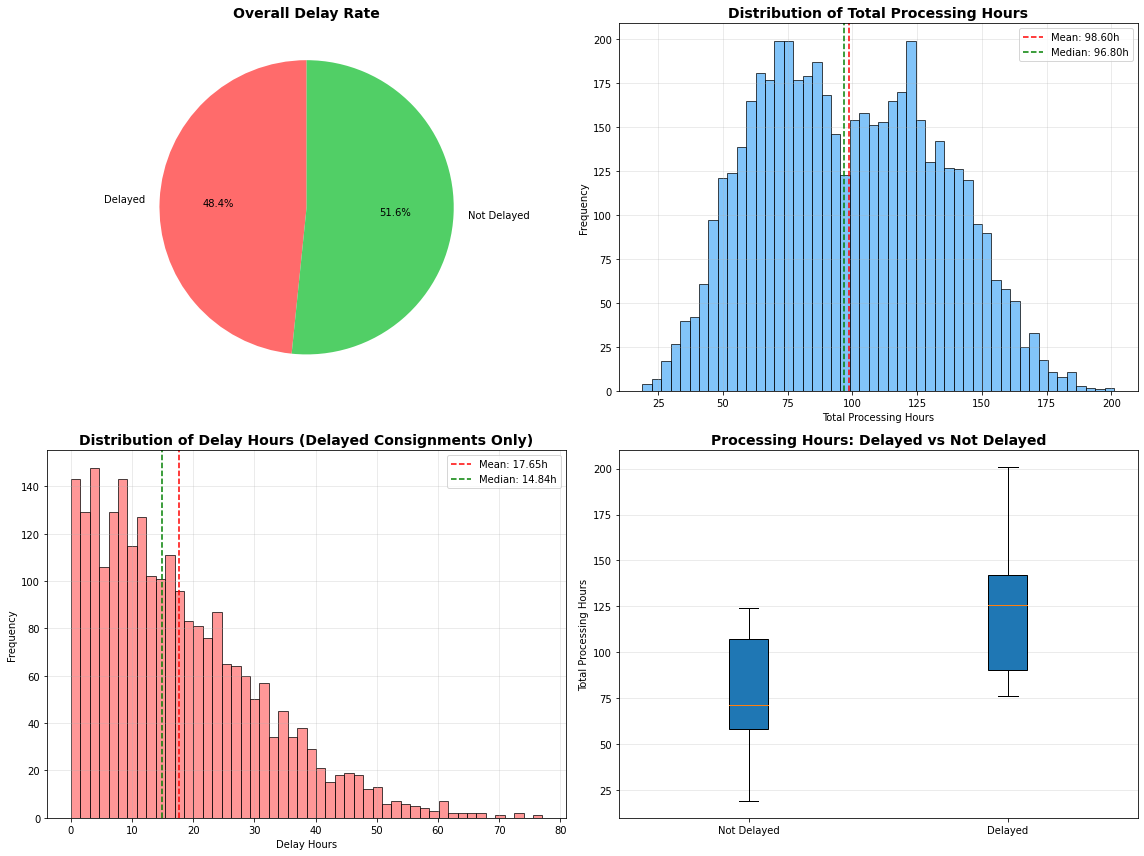


LONG-TAIL BEHAVIOR ANALYSIS:
------------------------------------------------------------
Consignments exceeding P95 (155.31h): 250
Consignments exceeding P99 (173.14h): 50
Maximum processing time: 201.06 hours


In [11]:
# Visualizations for overall delay landscape
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Delay vs Non-Delay Pie Chart
axes[0, 0].pie([delayed_count, total_consignments - delayed_count], 
                labels=['Delayed', 'Not Delayed'],
                autopct='%1.1f%%',
                startangle=90,
                colors=['#ff6b6b', '#51cf66'])
axes[0, 0].set_title('Overall Delay Rate', fontsize=14, fontweight='bold')

# 2. Distribution of total_processing_hours
axes[0, 1].hist(df['total_processing_hours'], bins=50, edgecolor='black', alpha=0.7, color='#4dabf7')
axes[0, 1].axvline(df['total_processing_hours'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["total_processing_hours"].mean():.2f}h')
axes[0, 1].axvline(df['total_processing_hours'].median(), color='green', linestyle='--', 
                   label=f'Median: {df["total_processing_hours"].median():.2f}h')
axes[0, 1].set_xlabel('Total Processing Hours')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Total Processing Hours', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Distribution of delay_hours (for delayed consignments only)
if len(delayed_df) > 0:
    axes[1, 0].hist(delayed_df['delay_hours'], bins=50, edgecolor='black', alpha=0.7, color='#ff6b6b')
    axes[1, 0].axvline(delayed_df['delay_hours'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {delayed_df["delay_hours"].mean():.2f}h')
    axes[1, 0].axvline(delayed_df['delay_hours'].median(), color='green', linestyle='--', 
                       label=f'Median: {delayed_df["delay_hours"].median():.2f}h')
    axes[1, 0].set_xlabel('Delay Hours')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Delay Hours (Delayed Consignments Only)', 
                         fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No delayed consignments', 
                    ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Distribution of Delay Hours', fontsize=14, fontweight='bold')

# 4. Box plot showing outliers
box_data = [df[df['delayed_flag'] == 0]['total_processing_hours'], 
            df[df['delayed_flag'] == 1]['total_processing_hours']]
axes[1, 1].boxplot(box_data, labels=['Not Delayed', 'Delayed'], patch_artist=True)
axes[1, 1].set_ylabel('Total Processing Hours')
axes[1, 1].set_title('Processing Hours: Delayed vs Not Delayed', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Check for long-tail behavior
print("\nLONG-TAIL BEHAVIOR ANALYSIS:")
print("-" * 60)
print(f"Consignments exceeding P95 ({df['total_processing_hours'].quantile(0.95):.2f}h): "
      f"{(df['total_processing_hours'] > df['total_processing_hours'].quantile(0.95)).sum()}")
print(f"Consignments exceeding P99 ({df['total_processing_hours'].quantile(0.99):.2f}h): "
      f"{(df['total_processing_hours'] > df['total_processing_hours'].quantile(0.99)).sum()}")
print(f"Maximum processing time: {df['total_processing_hours'].max():.2f} hours")


## 2. Delays by Origin Country


In [12]:
# Analyze delays by origin country
origin_analysis = df.groupby('origin_country').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean',
    'customs_release_hours': 'median',
    'terminal_dwell_hours': 'median'
}).round(2)

origin_analysis.columns = ['Total_Consignments', 'Delayed_Count', 'Delay_Rate', 
                           'Avg_Processing_Hours', 'Median_Customs_Hours', 
                           'Median_Dwell_Hours']
origin_analysis['Delay_Rate_Pct'] = (origin_analysis['Delay_Rate'] * 100).round(2)
origin_analysis = origin_analysis.sort_values('Delay_Rate', ascending=False)

print("=" * 80)
print("DELAYS BY ORIGIN COUNTRY")
print("=" * 80)
print(origin_analysis.to_string())
print("\n" + "=" * 80)


DELAYS BY ORIGIN COUNTRY
                Total_Consignments  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Median_Customs_Hours  Median_Dwell_Hours  Delay_Rate_Pct
origin_country                                                                                                                               
RW                            1015            525        0.52                100.51                 49.25               49.29            52.0
UG                             995            497        0.50                 98.74                 47.04               49.52            50.0
ET                             998            484        0.48                 98.92                 47.56               48.63            48.0
KE                             989            452        0.46                 97.48                 45.13               51.16            46.0
TZ                            1003            461        0.46                 97.31                 45.96               47.

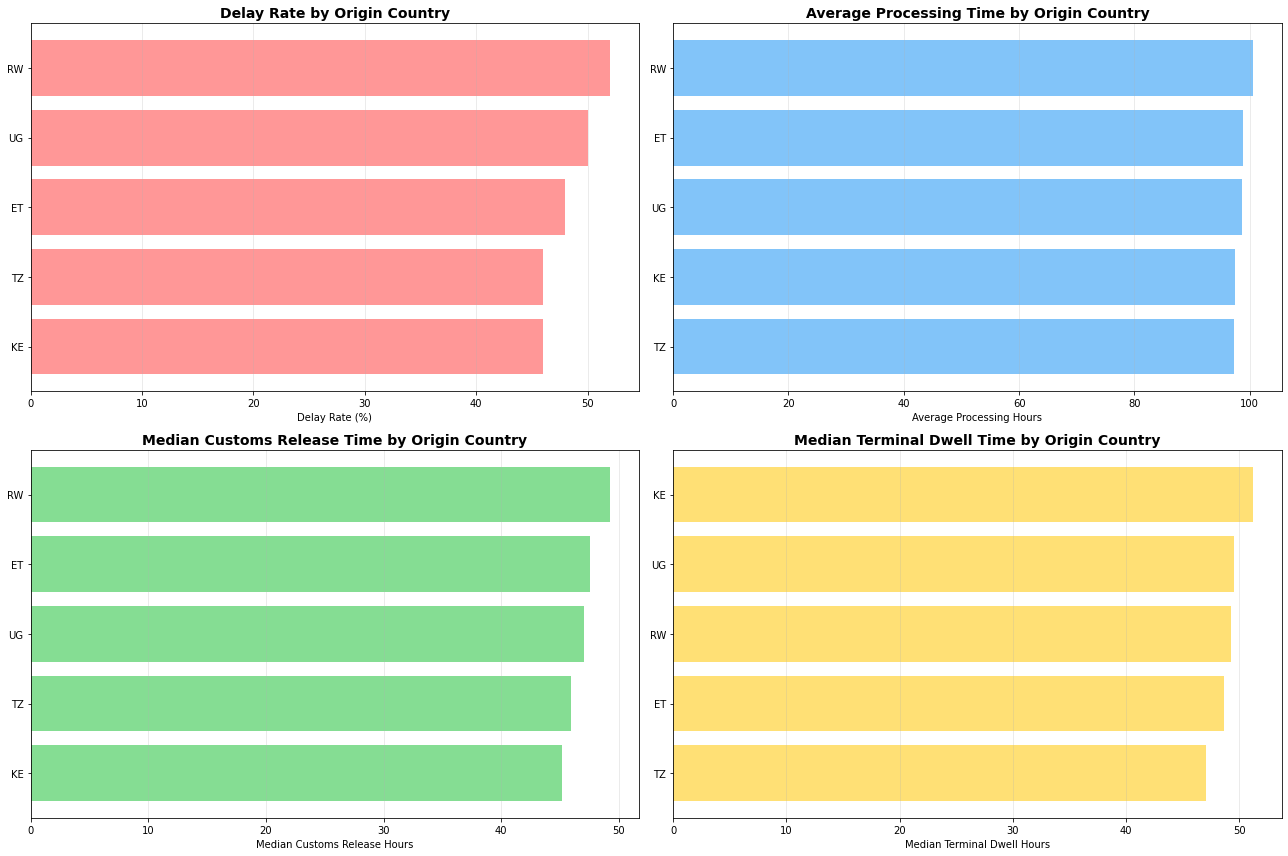


TOP 5 ORIGIN COUNTRIES WITH HIGHEST DELAY RATES:
--------------------------------------------------------------------------------
                Total_Consignments  Delayed_Count  Delay_Rate_Pct  Avg_Processing_Hours
origin_country                                                                         
RW                            1015            525            52.0                100.51
UG                             995            497            50.0                 98.74
ET                             998            484            48.0                 98.92
KE                             989            452            46.0                 97.48
TZ                            1003            461            46.0                 97.31


In [13]:
# Visualizations for origin country analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Delay rate by origin country
origin_delay_rate = origin_analysis.sort_values('Delay_Rate', ascending=True)
axes[0, 0].barh(range(len(origin_delay_rate)), origin_delay_rate['Delay_Rate_Pct'], 
                color='#ff6b6b', alpha=0.7)
axes[0, 0].set_yticks(range(len(origin_delay_rate)))
axes[0, 0].set_yticklabels(origin_delay_rate.index)
axes[0, 0].set_xlabel('Delay Rate (%)')
axes[0, 0].set_title('Delay Rate by Origin Country', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='x')

# 2. Average processing hours by origin country
origin_avg_processing = origin_analysis.sort_values('Avg_Processing_Hours', ascending=True)
axes[0, 1].barh(range(len(origin_avg_processing)), origin_avg_processing['Avg_Processing_Hours'], 
                color='#4dabf7', alpha=0.7)
axes[0, 1].set_yticks(range(len(origin_avg_processing)))
axes[0, 1].set_yticklabels(origin_avg_processing.index)
axes[0, 1].set_xlabel('Average Processing Hours')
axes[0, 1].set_title('Average Processing Time by Origin Country', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='x')

# 3. Median customs release hours by origin country
origin_customs = origin_analysis.sort_values('Median_Customs_Hours', ascending=True)
axes[1, 0].barh(range(len(origin_customs)), origin_customs['Median_Customs_Hours'], 
                color='#51cf66', alpha=0.7)
axes[1, 0].set_yticks(range(len(origin_customs)))
axes[1, 0].set_yticklabels(origin_customs.index)
axes[1, 0].set_xlabel('Median Customs Release Hours')
axes[1, 0].set_title('Median Customs Release Time by Origin Country', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='x')

# 4. Median terminal dwell hours by origin country
origin_dwell = origin_analysis.sort_values('Median_Dwell_Hours', ascending=True)
axes[1, 1].barh(range(len(origin_dwell)), origin_dwell['Median_Dwell_Hours'], 
                color='#ffd43b', alpha=0.7)
axes[1, 1].set_yticks(range(len(origin_dwell)))
axes[1, 1].set_yticklabels(origin_dwell.index)
axes[1, 1].set_xlabel('Median Terminal Dwell Hours')
axes[1, 1].set_title('Median Terminal Dwell Time by Origin Country', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Top 5 origin countries with highest delay rates
print("\nTOP 5 ORIGIN COUNTRIES WITH HIGHEST DELAY RATES:")
print("-" * 80)
print(origin_analysis.head(5)[['Total_Consignments', 'Delayed_Count', 'Delay_Rate_Pct', 
                                'Avg_Processing_Hours']].to_string())


## 3. Delays by Destination Country


In [14]:
# Analyze delays by destination country
dest_analysis = df.groupby('destination_country').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean',
    'terminal_dwell_hours': 'median',
    'shipment_mode': lambda x: x.value_counts().to_dict()
}).round(2)

# Flatten column names
dest_analysis.columns = ['Total_Consignments', 'Delayed_Count', 'Delay_Rate', 
                         'Avg_Processing_Hours', 'Median_Dwell_Hours', 'Shipment_Mode_Dict']

# Calculate AIR vs SEA split
dest_analysis['AIR_Count'] = dest_analysis['Shipment_Mode_Dict'].apply(
    lambda x: x.get('AIR', 0) if isinstance(x, dict) else 0
)
dest_analysis['SEA_Count'] = dest_analysis['Shipment_Mode_Dict'].apply(
    lambda x: x.get('SEA', 0) if isinstance(x, dict) else 0
)
dest_analysis['AIR_Pct'] = (dest_analysis['AIR_Count'] / dest_analysis['Total_Consignments'] * 100).round(2)
dest_analysis['SEA_Pct'] = (dest_analysis['SEA_Count'] / dest_analysis['Total_Consignments'] * 100).round(2)

dest_analysis['Delay_Rate_Pct'] = (dest_analysis['Delay_Rate'] * 100).round(2)
dest_analysis = dest_analysis.sort_values('Delay_Rate', ascending=False)

# Drop the dict column for display
dest_display = dest_analysis.drop('Shipment_Mode_Dict', axis=1)

print("=" * 100)
print("DELAYS BY DESTINATION COUNTRY")
print("=" * 100)
print(dest_display.to_string())
print("\n" + "=" * 100)


DELAYS BY DESTINATION COUNTRY
                     Total_Consignments  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Median_Dwell_Hours  AIR_Count  SEA_Count  AIR_Pct  SEA_Pct  Delay_Rate_Pct
destination_country                                                                                                                                                 
BE                                  729            374        0.51                 95.60               45.37        445        284    61.04    38.96            51.0
DE                                  653            334        0.51                 99.25               48.29        354        299    54.21    45.79            51.0
FR                                  738            355        0.48                100.18               52.44        379        359    51.36    48.64            48.0
UK                                  757            366        0.48                 99.67               49.56        392        365    51.78    48

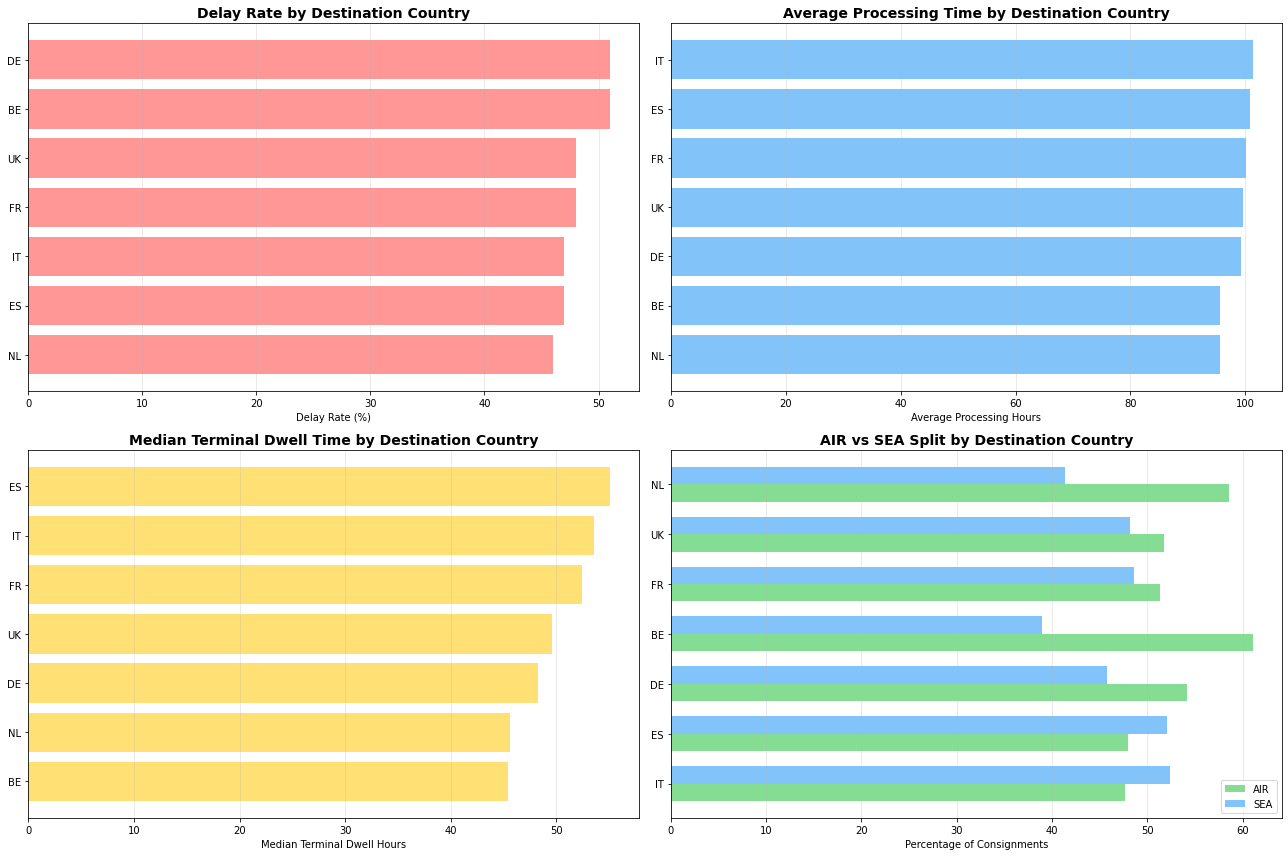


AIR vs SEA DELAY RATES BY DESTINATION:
--------------------------------------------------------------------------------
                                   Count  Delayed_Count  Delay_Rate  Delay_Rate_Pct
destination_country shipment_mode                                                  
BE                  AIR              445            204       0.458            45.8
                    SEA              284            170       0.599            59.9
DE                  AIR              354            158       0.446            44.6
                    SEA              299            176       0.589            58.9
ES                  AIR              296            129       0.436            43.6
                    SEA              321            162       0.505            50.5
FR                  AIR              379            146       0.385            38.5
                    SEA              359            209       0.582            58.2
IT                  AIR              24

In [15]:
# Visualizations for destination country analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Delay rate by destination country
dest_delay_rate = dest_analysis.sort_values('Delay_Rate', ascending=True)
axes[0, 0].barh(range(len(dest_delay_rate)), dest_delay_rate['Delay_Rate_Pct'], 
                color='#ff6b6b', alpha=0.7)
axes[0, 0].set_yticks(range(len(dest_delay_rate)))
axes[0, 0].set_yticklabels(dest_delay_rate.index)
axes[0, 0].set_xlabel('Delay Rate (%)')
axes[0, 0].set_title('Delay Rate by Destination Country', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='x')

# 2. Average processing hours by destination country
dest_avg_processing = dest_analysis.sort_values('Avg_Processing_Hours', ascending=True)
axes[0, 1].barh(range(len(dest_avg_processing)), dest_avg_processing['Avg_Processing_Hours'], 
                color='#4dabf7', alpha=0.7)
axes[0, 1].set_yticks(range(len(dest_avg_processing)))
axes[0, 1].set_yticklabels(dest_avg_processing.index)
axes[0, 1].set_xlabel('Average Processing Hours')
axes[0, 1].set_title('Average Processing Time by Destination Country', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='x')

# 3. Median dwell time by destination country
dest_dwell = dest_analysis.sort_values('Median_Dwell_Hours', ascending=True)
axes[1, 0].barh(range(len(dest_dwell)), dest_dwell['Median_Dwell_Hours'], 
                color='#ffd43b', alpha=0.7)
axes[1, 0].set_yticks(range(len(dest_dwell)))
axes[1, 0].set_yticklabels(dest_dwell.index)
axes[1, 0].set_xlabel('Median Terminal Dwell Hours')
axes[1, 0].set_title('Median Terminal Dwell Time by Destination Country', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='x')

# 4. AIR vs SEA split by destination
x_pos = range(len(dest_analysis))
width = 0.35
dest_sorted = dest_analysis.sort_values('Total_Consignments', ascending=True)
axes[1, 1].barh([x - width/2 for x in x_pos], dest_sorted['AIR_Pct'], width, 
                label='AIR', color='#51cf66', alpha=0.7)
axes[1, 1].barh([x + width/2 for x in x_pos], dest_sorted['SEA_Pct'], width, 
                label='SEA', color='#4dabf7', alpha=0.7)
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels(dest_sorted.index)
axes[1, 1].set_xlabel('Percentage of Consignments')
axes[1, 1].set_title('AIR vs SEA Split by Destination Country', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Compare AIR vs SEA delay rates within each destination
print("\nAIR vs SEA DELAY RATES BY DESTINATION:")
print("-" * 80)
air_sea_dest = df.groupby(['destination_country', 'shipment_mode'])['delayed_flag'].agg(['count', 'sum', 'mean']).round(3)
air_sea_dest.columns = ['Count', 'Delayed_Count', 'Delay_Rate']
air_sea_dest['Delay_Rate_Pct'] = (air_sea_dest['Delay_Rate'] * 100).round(2)
print(air_sea_dest.to_string())


## 4. Port / Airport Performance Analysis


In [16]:
# Analyze origin port performance
origin_port_analysis = df.groupby('origin_port').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean',
    'customs_release_hours': 'mean',
    'terminal_dwell_hours': 'mean'
}).round(2)

origin_port_analysis.columns = ['Total_Consignments', 'Delayed_Count', 'Delay_Rate', 
                                'Avg_Processing_Hours', 'Avg_Customs_Hours', 
                                'Avg_Dwell_Hours']
origin_port_analysis['Delay_Rate_Pct'] = (origin_port_analysis['Delay_Rate'] * 100).round(2)
origin_port_analysis = origin_port_analysis.sort_values('Delay_Rate', ascending=False)

print("=" * 100)
print("ORIGIN PORT PERFORMANCE ANALYSIS")
print("=" * 100)
print(origin_port_analysis.to_string())
print("\n" + "=" * 100)


ORIGIN PORT PERFORMANCE ANALYSIS
                 Total_Consignments  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Avg_Customs_Hours  Avg_Dwell_Hours  Delay_Rate_Pct
origin_port                                                                                                                             
Kigali                         1015            525        0.52                100.51              49.34            51.18            52.0
Entebbe                         501            248        0.50                 99.80              47.74            52.06            50.0
Kampala-ICD                     494            249        0.50                 97.66              46.79            50.87            50.0
Addis Ababa-ADD                 998            484        0.48                 98.92              47.69            51.23            48.0
Nairobi-JKIA                    537            254        0.47                 98.31              45.28            53.03            47.0
Dar es S

In [17]:
# Analyze destination port performance
dest_port_analysis = df.groupby('destination_port').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean',
    'terminal_dwell_hours': 'mean',
    'customs_release_hours': 'mean'
}).round(2)

dest_port_analysis.columns = ['Total_Consignments', 'Delayed_Count', 'Delay_Rate', 
                               'Avg_Processing_Hours', 'Avg_Dwell_Hours', 
                               'Avg_Customs_Hours']
dest_port_analysis['Delay_Rate_Pct'] = (dest_port_analysis['Delay_Rate'] * 100).round(2)
dest_port_analysis = dest_port_analysis.sort_values('Delay_Rate', ascending=False)

print("=" * 100)
print("DESTINATION PORT PERFORMANCE ANALYSIS")
print("=" * 100)
print(dest_port_analysis.to_string())
print("\n" + "=" * 100)


DESTINATION PORT PERFORMANCE ANALYSIS
                  Total_Consignments  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Avg_Dwell_Hours  Avg_Customs_Hours  Delay_Rate_Pct
destination_port                                                                                                                         
Felixstowe                       384            203        0.53                103.56            54.08              49.48            53.0
Brussels                         364            188        0.52                 95.11            49.05              46.06            52.0
Hamburg                          348            180        0.52                100.09            51.83              48.26            52.0
Antwerp                          365            186        0.51                 96.09            49.56              46.52            51.0
Frankfurt                        305            154        0.50                 98.28            51.22              47.06            5

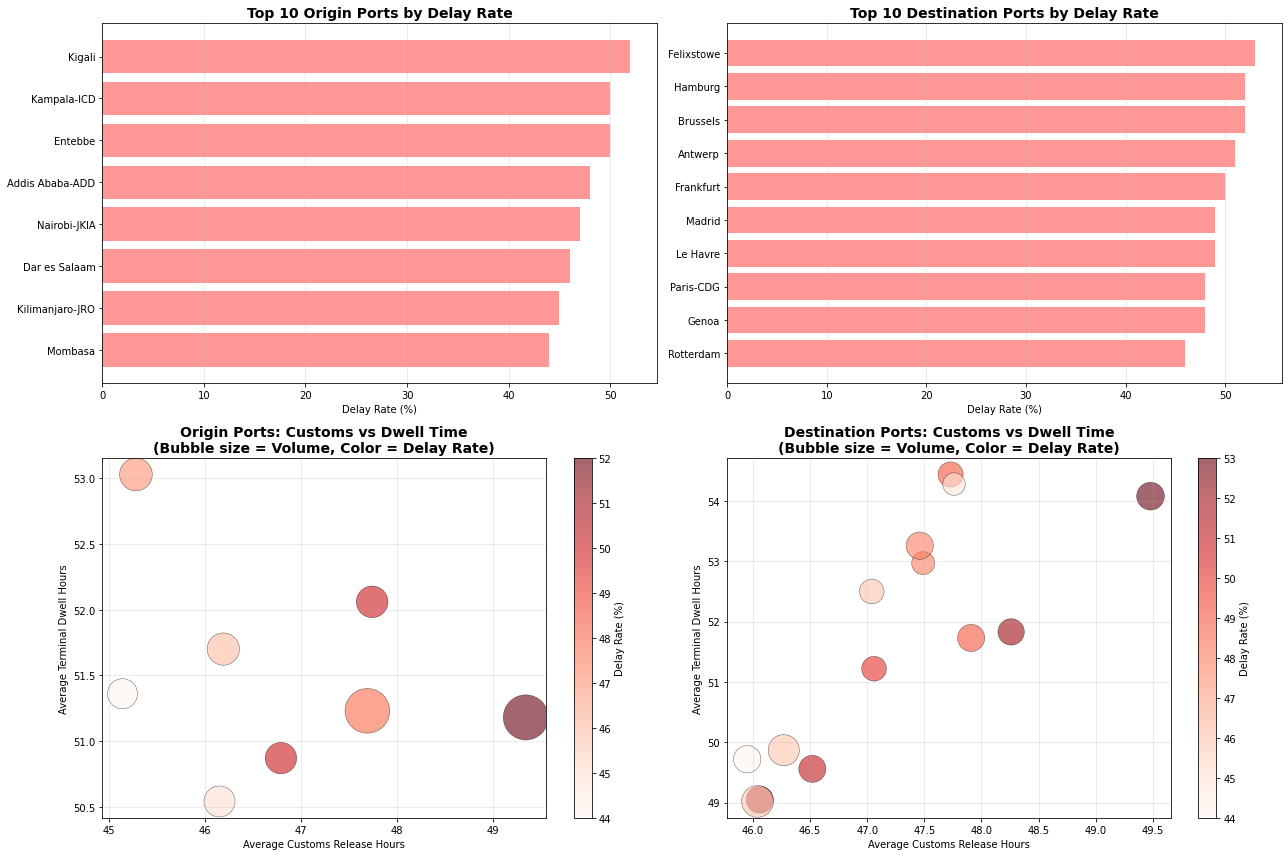


PORT BOTTLENECK ANALYSIS:
--------------------------------------------------------------------------------

Origin Ports with High Dwell but Normal Customs (Terminal Congestion):
              Avg_Dwell_Hours  Avg_Customs_Hours  Delay_Rate_Pct
origin_port                                                     
Nairobi-JKIA            53.03              45.28            47.0

Origin Ports with Slow Customs but Normal Dwell (Regulatory Bottleneck):
             Avg_Customs_Hours  Avg_Dwell_Hours  Delay_Rate_Pct
origin_port                                                    
Kigali                   49.34            51.18            52.0


In [18]:
# Visualizations for port performance
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Origin port delay rates (top 10)
top_origin_ports = origin_port_analysis.head(10).sort_values('Delay_Rate', ascending=True)
axes[0, 0].barh(range(len(top_origin_ports)), top_origin_ports['Delay_Rate_Pct'], 
                color='#ff6b6b', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_origin_ports)))
axes[0, 0].set_yticklabels(top_origin_ports.index)
axes[0, 0].set_xlabel('Delay Rate (%)')
axes[0, 0].set_title('Top 10 Origin Ports by Delay Rate', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='x')

# 2. Destination port delay rates (top 10)
top_dest_ports = dest_port_analysis.head(10).sort_values('Delay_Rate', ascending=True)
axes[0, 1].barh(range(len(top_dest_ports)), top_dest_ports['Delay_Rate_Pct'], 
                color='#ff6b6b', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_dest_ports)))
axes[0, 1].set_yticklabels(top_dest_ports.index)
axes[0, 1].set_xlabel('Delay Rate (%)')
axes[0, 1].set_title('Top 10 Destination Ports by Delay Rate', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='x')

# 3. Scatter: Customs vs Dwell time for origin ports (identify bottlenecks)
axes[1, 0].scatter(origin_port_analysis['Avg_Customs_Hours'], 
                   origin_port_analysis['Avg_Dwell_Hours'],
                   s=origin_port_analysis['Total_Consignments']*2, 
                   alpha=0.6, c=origin_port_analysis['Delay_Rate_Pct'], 
                   cmap='Reds', edgecolors='black', linewidth=0.5)
axes[1, 0].set_xlabel('Average Customs Release Hours')
axes[1, 0].set_ylabel('Average Terminal Dwell Hours')
axes[1, 0].set_title('Origin Ports: Customs vs Dwell Time\n(Bubble size = Volume, Color = Delay Rate)', 
                     fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0], label='Delay Rate (%)')

# 4. Scatter: Customs vs Dwell time for destination ports
axes[1, 1].scatter(dest_port_analysis['Avg_Customs_Hours'], 
                   dest_port_analysis['Avg_Dwell_Hours'],
                   s=dest_port_analysis['Total_Consignments']*2, 
                   alpha=0.6, c=dest_port_analysis['Delay_Rate_Pct'], 
                   cmap='Reds', edgecolors='black', linewidth=0.5)
axes[1, 1].set_xlabel('Average Customs Release Hours')
axes[1, 1].set_ylabel('Average Terminal Dwell Hours')
axes[1, 1].set_title('Destination Ports: Customs vs Dwell Time\n(Bubble size = Volume, Color = Delay Rate)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1], label='Delay Rate (%)')

plt.tight_layout()
plt.show()

# Identify bottleneck patterns
print("\nPORT BOTTLENECK ANALYSIS:")
print("-" * 80)
print("\nOrigin Ports with High Dwell but Normal Customs (Terminal Congestion):")
high_dwell_origin = origin_port_analysis[
    (origin_port_analysis['Avg_Dwell_Hours'] > origin_port_analysis['Avg_Dwell_Hours'].quantile(0.75)) &
    (origin_port_analysis['Avg_Customs_Hours'] <= origin_port_analysis['Avg_Customs_Hours'].median())
].sort_values('Avg_Dwell_Hours', ascending=False)
print(high_dwell_origin[['Avg_Dwell_Hours', 'Avg_Customs_Hours', 'Delay_Rate_Pct']].to_string())

print("\nOrigin Ports with Slow Customs but Normal Dwell (Regulatory Bottleneck):")
slow_customs_origin = origin_port_analysis[
    (origin_port_analysis['Avg_Customs_Hours'] > origin_port_analysis['Avg_Customs_Hours'].quantile(0.75)) &
    (origin_port_analysis['Avg_Dwell_Hours'] <= origin_port_analysis['Avg_Dwell_Hours'].median())
].sort_values('Avg_Customs_Hours', ascending=False)
print(slow_customs_origin[['Avg_Customs_Hours', 'Avg_Dwell_Hours', 'Delay_Rate_Pct']].to_string())


## 5. Time-of-Day Effects (Day vs Night)


In [19]:
# Extract time features from created_at
df['hour_of_day'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.day_name()

# Create time buckets
def get_time_bucket(hour):
    if 0 <= hour < 6:
        return 'Night (00:00-05:59)'
    elif 6 <= hour < 12:
        return 'Morning (06:00-11:59)'
    elif 12 <= hour < 18:
        return 'Afternoon (12:00-17:59)'
    else:
        return 'Evening (18:00-23:59)'

df['time_of_day_bucket'] = df['hour_of_day'].apply(get_time_bucket)

# Analyze time-of-day effects
time_analysis = df.groupby('time_of_day_bucket').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean',
    'customs_release_hours': 'mean',
    'terminal_dwell_hours': 'mean'
}).round(2)

time_analysis.columns = ['Total_Consignments', 'Delayed_Count', 'Delay_Rate', 
                         'Avg_Processing_Hours', 'Avg_Customs_Hours', 'Avg_Dwell_Hours']
time_analysis['Delay_Rate_Pct'] = (time_analysis['Delay_Rate'] * 100).round(2)

# Reorder for logical display
time_order = ['Night (00:00-05:59)', 'Morning (06:00-11:59)', 
              'Afternoon (12:00-17:59)', 'Evening (18:00-23:59)']
time_analysis = time_analysis.reindex(time_order)

print("=" * 100)
print("TIME-OF-DAY EFFECTS ANALYSIS")
print("=" * 100)
print(time_analysis.to_string())
print("\n" + "=" * 100)


TIME-OF-DAY EFFECTS ANALYSIS
                         Total_Consignments  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Avg_Customs_Hours  Avg_Dwell_Hours  Delay_Rate_Pct
time_of_day_bucket                                                                                                                              
Night (00:00-05:59)                    1231            616        0.50                 99.68              47.69            51.99            50.0
Morning (06:00-11:59)                  1326            633        0.48                 98.29              46.89            51.40            48.0
Afternoon (12:00-17:59)                1244            594        0.48                 98.23              47.04            51.19            48.0
Evening (18:00-23:59)                  1199            576        0.48                 98.22              46.98            51.24            48.0



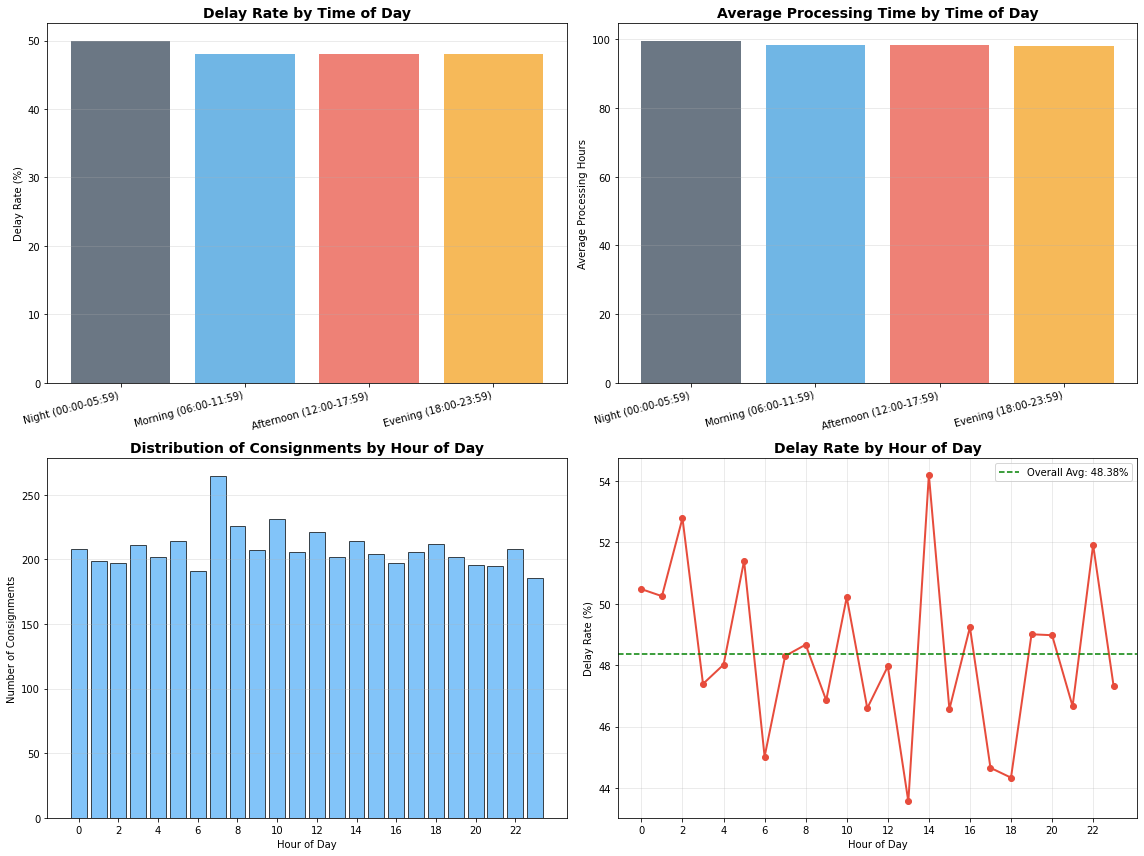


NIGHT vs DAY COMPARISON:
--------------------------------------------------------------------------------
Night Consignments:
  Count: 1,231
  Delay Rate: 50.04%
  Avg Processing Hours: 99.68

Day Consignments:
  Count: 3,769
  Delay Rate: 47.84%
  Avg Processing Hours: 98.25


In [20]:
# Visualizations for time-of-day effects
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Delay rate by time bucket
axes[0, 0].bar(range(len(time_analysis)), time_analysis['Delay_Rate_Pct'], 
               color=['#2c3e50', '#3498db', '#e74c3c', '#f39c12'], alpha=0.7)
axes[0, 0].set_xticks(range(len(time_analysis)))
axes[0, 0].set_xticklabels(time_analysis.index, rotation=15, ha='right')
axes[0, 0].set_ylabel('Delay Rate (%)')
axes[0, 0].set_title('Delay Rate by Time of Day', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Average processing hours by time bucket
axes[0, 1].bar(range(len(time_analysis)), time_analysis['Avg_Processing_Hours'], 
               color=['#2c3e50', '#3498db', '#e74c3c', '#f39c12'], alpha=0.7)
axes[0, 1].set_xticks(range(len(time_analysis)))
axes[0, 1].set_xticklabels(time_analysis.index, rotation=15, ha='right')
axes[0, 1].set_ylabel('Average Processing Hours')
axes[0, 1].set_title('Average Processing Time by Time of Day', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Distribution of consignments by hour of day
hour_dist = df['hour_of_day'].value_counts().sort_index()
axes[1, 0].bar(hour_dist.index, hour_dist.values, color='#4dabf7', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Consignments')
axes[1, 0].set_title('Distribution of Consignments by Hour of Day', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Delay rate by hour of day
hour_delay = df.groupby('hour_of_day')['delayed_flag'].mean() * 100
axes[1, 1].plot(hour_delay.index, hour_delay.values, marker='o', linewidth=2, 
                markersize=6, color='#e74c3c')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Delay Rate (%)')
axes[1, 1].set_title('Delay Rate by Hour of Day', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(alpha=0.3)
axes[1, 1].axhline(y=df['delayed_flag'].mean() * 100, color='green', 
                   linestyle='--', label=f'Overall Avg: {df["delayed_flag"].mean()*100:.2f}%')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Night vs Day comparison
print("\nNIGHT vs DAY COMPARISON:")
print("-" * 80)
night_df = df[df['time_of_day_bucket'] == 'Night (00:00-05:59)']
day_df = df[df['time_of_day_bucket'].isin(['Morning (06:00-11:59)', 
                                           'Afternoon (12:00-17:59)', 
                                           'Evening (18:00-23:59)'])]

print(f"Night Consignments:")
print(f"  Count: {len(night_df):,}")
print(f"  Delay Rate: {night_df['delayed_flag'].mean()*100:.2f}%")
print(f"  Avg Processing Hours: {night_df['total_processing_hours'].mean():.2f}")

print(f"\nDay Consignments:")
print(f"  Count: {len(day_df):,}")
print(f"  Delay Rate: {day_df['delayed_flag'].mean()*100:.2f}%")
print(f"  Avg Processing Hours: {day_df['total_processing_hours'].mean():.2f}")


## 6. Day-of-Week Analysis


In [21]:
# Analyze day-of-week effects
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=weekday_order, ordered=True)

weekday_analysis = df.groupby('day_of_week', observed=True).agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean',
    'customs_release_hours': 'mean',
    'terminal_dwell_hours': 'mean',
    'is_weekend_created': 'sum'
}).round(2)

weekday_analysis.columns = ['Total_Consignments', 'Delayed_Count', 'Delay_Rate', 
                             'Avg_Processing_Hours', 'Avg_Customs_Hours', 
                             'Avg_Dwell_Hours', 'Weekend_Created_Count']
weekday_analysis['Delay_Rate_Pct'] = (weekday_analysis['Delay_Rate'] * 100).round(2)

print("=" * 100)
print("DAY-OF-WEEK ANALYSIS")
print("=" * 100)
print(weekday_analysis.to_string())
print("\n" + "=" * 100)


DAY-OF-WEEK ANALYSIS
             Total_Consignments  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Avg_Customs_Hours  Avg_Dwell_Hours  Weekend_Created_Count  Delay_Rate_Pct
day_of_week                                                                                                                                                
Monday                      717            301        0.42                 97.23              46.07            51.15                      0            42.0
Tuesday                     685            291        0.42                 96.56              45.76            50.80                      0            42.0
Wednesday                   712            286        0.40                 94.82              45.38            49.44                      0            40.0
Thursday                    763            302        0.40                 93.35              44.58            48.78                      0            40.0
Friday                      732            

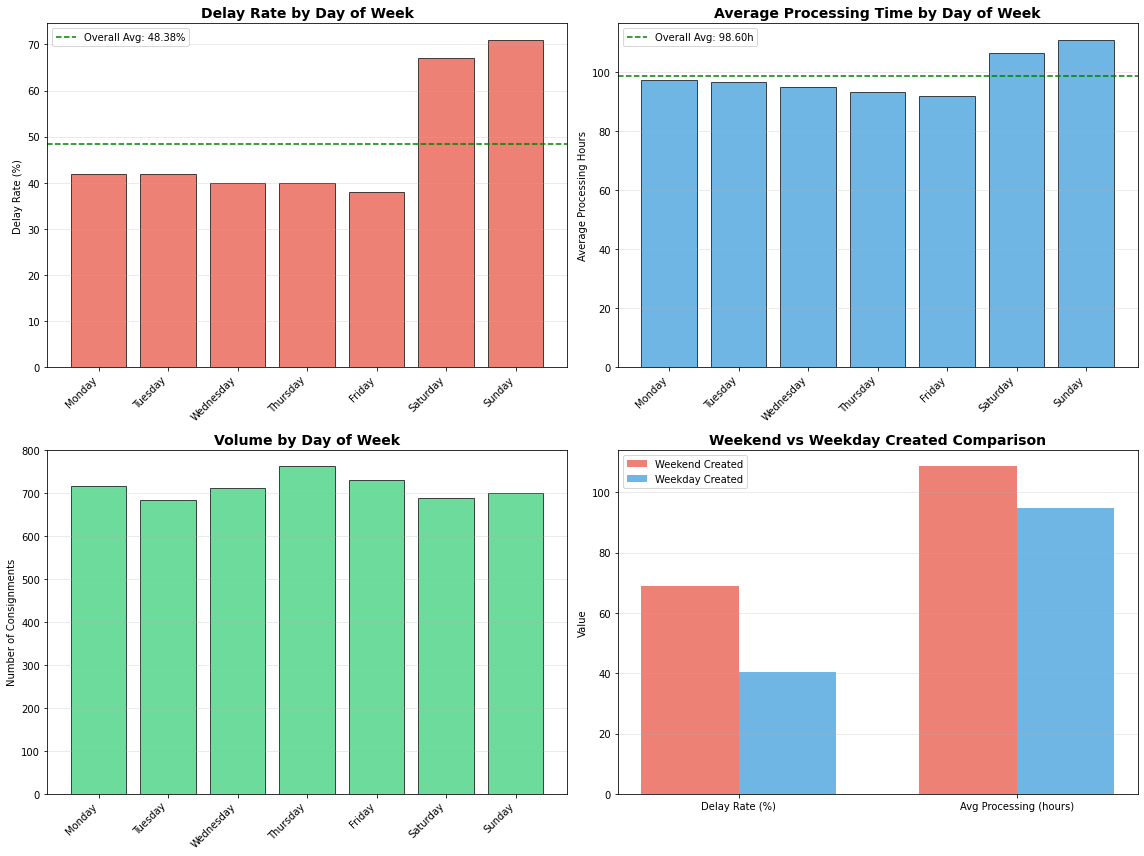


WEEKEND vs WEEKDAY SUMMARY:
--------------------------------------------------------------------------------
Weekend Created Consignments: 1,391
  Delay Rate: 69.09%
  Avg Processing: 108.61 hours

Weekday Created Consignments: 3,609
  Delay Rate: 40.40%
  Avg Processing: 94.74 hours


In [22]:
# Visualizations for day-of-week analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Delay rate by weekday
axes[0, 0].bar(range(len(weekday_analysis)), weekday_analysis['Delay_Rate_Pct'], 
               color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(weekday_analysis)))
axes[0, 0].set_xticklabels(weekday_analysis.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('Delay Rate (%)')
axes[0, 0].set_title('Delay Rate by Day of Week', fontsize=14, fontweight='bold')
axes[0, 0].axhline(y=df['delayed_flag'].mean() * 100, color='green', 
                   linestyle='--', label=f'Overall Avg: {df["delayed_flag"].mean()*100:.2f}%')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Average processing time by weekday
axes[0, 1].bar(range(len(weekday_analysis)), weekday_analysis['Avg_Processing_Hours'], 
               color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(len(weekday_analysis)))
axes[0, 1].set_xticklabels(weekday_analysis.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Average Processing Hours')
axes[0, 1].set_title('Average Processing Time by Day of Week', fontsize=14, fontweight='bold')
axes[0, 1].axhline(y=df['total_processing_hours'].mean(), color='green', 
                   linestyle='--', label=f'Overall Avg: {df["total_processing_hours"].mean():.2f}h')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Volume by weekday
axes[1, 0].bar(range(len(weekday_analysis)), weekday_analysis['Total_Consignments'], 
               color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(len(weekday_analysis)))
axes[1, 0].set_xticklabels(weekday_analysis.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Number of Consignments')
axes[1, 0].set_title('Volume by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Weekend vs Weekday comparison
weekend_delay = df[df['is_weekend_created'] == 1]['delayed_flag'].mean() * 100
weekday_delay = df[df['is_weekend_created'] == 0]['delayed_flag'].mean() * 100

weekend_processing = df[df['is_weekend_created'] == 1]['total_processing_hours'].mean()
weekday_processing = df[df['is_weekend_created'] == 0]['total_processing_hours'].mean()

comparison_data = {
    'Weekend Created': [weekend_delay, weekend_processing],
    'Weekday Created': [weekday_delay, weekday_processing]
}
comparison_df = pd.DataFrame(comparison_data, index=['Delay Rate (%)', 'Avg Processing (hours)'])

x = range(len(comparison_df))
width = 0.35
axes[1, 1].bar([i - width/2 for i in x], comparison_df['Weekend Created'], width, 
               label='Weekend Created', color='#e74c3c', alpha=0.7)
axes[1, 1].bar([i + width/2 for i in x], comparison_df['Weekday Created'], width, 
               label='Weekday Created', color='#3498db', alpha=0.7)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_df.index)
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_title('Weekend vs Weekday Created Comparison', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nWEEKEND vs WEEKDAY SUMMARY:")
print("-" * 80)
print(f"Weekend Created Consignments: {df['is_weekend_created'].sum():,}")
print(f"  Delay Rate: {weekend_delay:.2f}%")
print(f"  Avg Processing: {weekend_processing:.2f} hours")
print(f"\nWeekday Created Consignments: {(df['is_weekend_created'] == 0).sum():,}")
print(f"  Delay Rate: {weekday_delay:.2f}%")
print(f"  Avg Processing: {weekday_processing:.2f} hours")


## 7. Commodity-Level Delay Patterns


In [23]:
# Analyze commodity-level delay patterns
commodity_analysis = df.groupby('commodity').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean',
    'customs_release_hours': 'mean',
    'terminal_dwell_hours': 'mean'
}).round(2)

commodity_analysis.columns = ['Total_Consignments', 'Delayed_Count', 'Delay_Rate', 
                               'Avg_Processing_Hours', 'Avg_Customs_Hours', 
                               'Avg_Dwell_Hours']
commodity_analysis['Delay_Rate_Pct'] = (commodity_analysis['Delay_Rate'] * 100).round(2)
commodity_analysis = commodity_analysis.sort_values('Delay_Rate', ascending=False)

print("=" * 100)
print("COMMODITY-LEVEL DELAY PATTERNS")
print("=" * 100)
print(commodity_analysis.to_string())
print("\n" + "=" * 100)


COMMODITY-LEVEL DELAY PATTERNS
                Total_Consignments  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Avg_Customs_Hours  Avg_Dwell_Hours  Delay_Rate_Pct
commodity                                                                                                                              
Tea                            639            385        0.60                129.51              56.98            72.53            60.0
Vegetables Mix                 579            314        0.54                127.89              56.35            71.54            54.0
Pineapples                     638            333        0.52                127.26              56.29            70.96            52.0
Avocados                       606            298        0.49                115.43              52.44            62.99            49.0
Cut Flowers                    653            285        0.44                 72.83              38.99            33.83            44.0
Fresh Herbs      

In [24]:
# AIR vs SEA comparison per commodity
commodity_mode_analysis = df.groupby(['commodity', 'shipment_mode']).agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean'
}).round(2)

commodity_mode_analysis.columns = ['Count', 'Delayed_Count', 'Delay_Rate', 'Avg_Processing_Hours']
commodity_mode_analysis['Delay_Rate_Pct'] = (commodity_mode_analysis['Delay_Rate'] * 100).round(2)

print("=" * 100)
print("COMMODITY DELAY PATTERNS BY SHIPMENT MODE (AIR vs SEA)")
print("=" * 100)
print(commodity_mode_analysis.to_string())
print("\n" + "=" * 100)


COMMODITY DELAY PATTERNS BY SHIPMENT MODE (AIR vs SEA)
                              Count  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Delay_Rate_Pct
commodity      shipment_mode                                                                        
Avocados       AIR              154             40        0.26                 74.77            26.0
               SEA              452            258        0.57                129.28            57.0
Cut Flowers    AIR              653            285        0.44                 72.83            44.0
Fresh Beans    AIR              618            251        0.41                 72.27            41.0
Fresh Herbs    AIR              624            275        0.44                 73.41            44.0
Mangoes        AIR              643            278        0.43                 73.16            43.0
Pineapples     SEA              638            333        0.52                127.26            52.0
Tea            SEA              639 

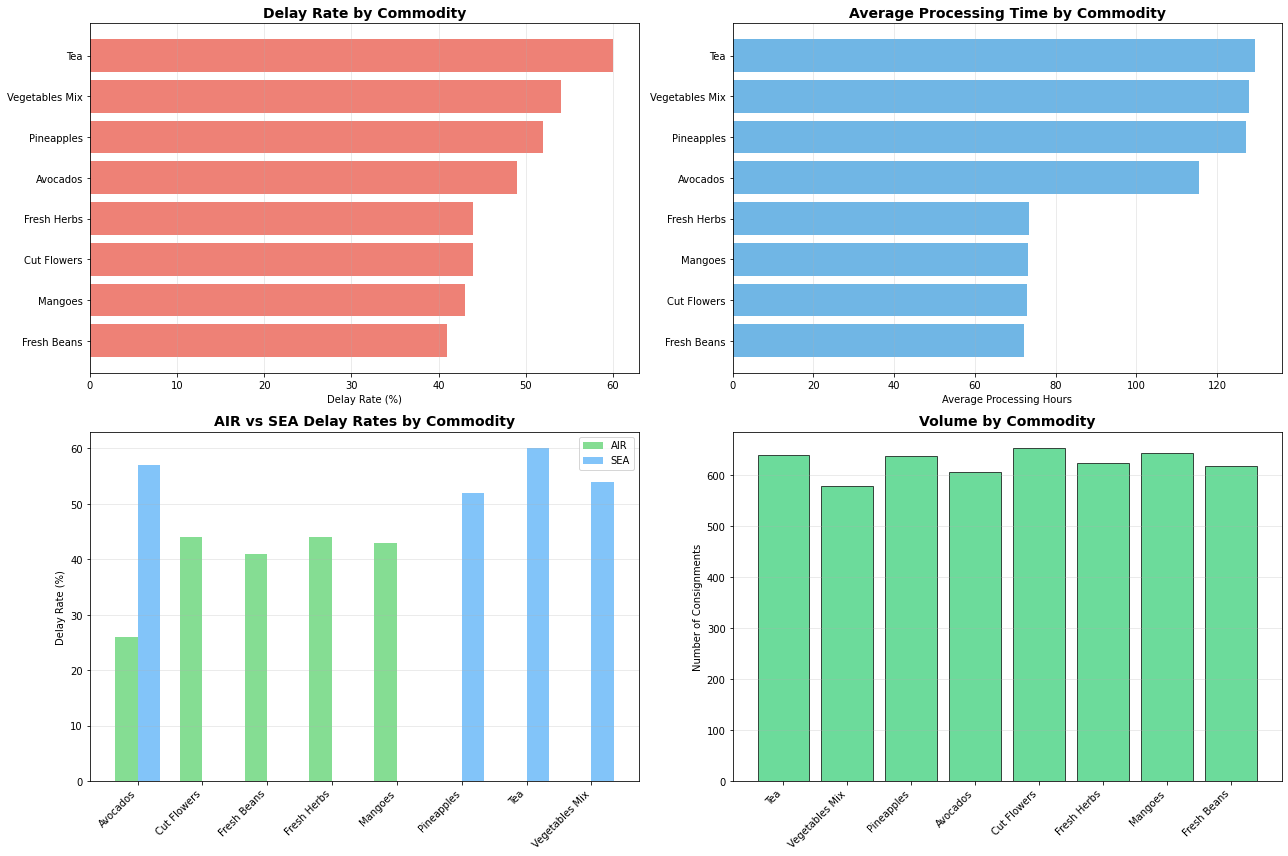


TOP 5 COMMODITIES BY DELAY RATE:
--------------------------------------------------------------------------------
                Total_Consignments  Delayed_Count  Delay_Rate_Pct  Avg_Processing_Hours
commodity                                                                              
Tea                            639            385            60.0                129.51
Vegetables Mix                 579            314            54.0                127.89
Pineapples                     638            333            52.0                127.26
Avocados                       606            298            49.0                115.43
Cut Flowers                    653            285            44.0                 72.83


In [25]:
# Visualizations for commodity analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Delay rate by commodity
commodity_delay = commodity_analysis.sort_values('Delay_Rate', ascending=True)
axes[0, 0].barh(range(len(commodity_delay)), commodity_delay['Delay_Rate_Pct'], 
                color='#e74c3c', alpha=0.7)
axes[0, 0].set_yticks(range(len(commodity_delay)))
axes[0, 0].set_yticklabels(commodity_delay.index)
axes[0, 0].set_xlabel('Delay Rate (%)')
axes[0, 0].set_title('Delay Rate by Commodity', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='x')

# 2. Average processing time by commodity
commodity_processing = commodity_analysis.sort_values('Avg_Processing_Hours', ascending=True)
axes[0, 1].barh(range(len(commodity_processing)), commodity_processing['Avg_Processing_Hours'], 
                color='#3498db', alpha=0.7)
axes[0, 1].set_yticks(range(len(commodity_processing)))
axes[0, 1].set_yticklabels(commodity_processing.index)
axes[0, 1].set_xlabel('Average Processing Hours')
axes[0, 1].set_title('Average Processing Time by Commodity', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='x')

# 3. AIR vs SEA delay rates by commodity
commodities = commodity_mode_analysis.index.get_level_values(0).unique()
air_delays = []
sea_delays = []
commodity_labels = []

for commodity in commodities:
    if (commodity, 'AIR') in commodity_mode_analysis.index:
        air_delays.append(commodity_mode_analysis.loc[(commodity, 'AIR'), 'Delay_Rate_Pct'])
    else:
        air_delays.append(0)
    
    if (commodity, 'SEA') in commodity_mode_analysis.index:
        sea_delays.append(commodity_mode_analysis.loc[(commodity, 'SEA'), 'Delay_Rate_Pct'])
    else:
        sea_delays.append(0)
    
    commodity_labels.append(commodity)

x = range(len(commodities))
width = 0.35
axes[1, 0].bar([i - width/2 for i in x], air_delays, width, 
               label='AIR', color='#51cf66', alpha=0.7)
axes[1, 0].bar([i + width/2 for i in x], sea_delays, width, 
               label='SEA', color='#4dabf7', alpha=0.7)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(commodity_labels, rotation=45, ha='right')
axes[1, 0].set_ylabel('Delay Rate (%)')
axes[1, 0].set_title('AIR vs SEA Delay Rates by Commodity', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Volume by commodity
axes[1, 1].bar(range(len(commodity_analysis)), commodity_analysis['Total_Consignments'], 
               color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 1].set_xticks(range(len(commodity_analysis)))
axes[1, 1].set_xticklabels(commodity_analysis.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Number of Consignments')
axes[1, 1].set_title('Volume by Commodity', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Top commodities by delay rate
print("\nTOP 5 COMMODITIES BY DELAY RATE:")
print("-" * 80)
print(commodity_analysis.head(5)[['Total_Consignments', 'Delayed_Count', 'Delay_Rate_Pct', 
                                    'Avg_Processing_Hours']].to_string())


## 8. Countries with Longest Processing Times (Not Just Delays)


In [26]:
# Rank countries by mean processing time (separate for origin and destination)
origin_processing_rank = df.groupby('origin_country')['total_processing_hours'].mean().sort_values(ascending=False)
dest_processing_rank = df.groupby('destination_country')['total_processing_hours'].mean().sort_values(ascending=False)

# Rank countries by delay rate
origin_delay_rank = df.groupby('origin_country')['delayed_flag'].mean().sort_values(ascending=False) * 100
dest_delay_rank = df.groupby('destination_country')['delayed_flag'].mean().sort_values(ascending=False) * 100

print("=" * 100)
print("COUNTRIES RANKED BY PROCESSING TIME vs DELAY RATE")
print("=" * 100)

print("\nORIGIN COUNTRIES - Ranked by Mean Processing Time:")
print("-" * 100)
origin_processing_df = pd.DataFrame({
    'Mean_Processing_Hours': origin_processing_rank,
    'Delay_Rate_Pct': origin_delay_rank[origin_processing_rank.index]
}).round(2)
print(origin_processing_df.to_string())

print("\n\nORIGIN COUNTRIES - Ranked by Delay Rate:")
print("-" * 100)
origin_delay_df = pd.DataFrame({
    'Delay_Rate_Pct': origin_delay_rank,
    'Mean_Processing_Hours': origin_processing_rank[origin_delay_rank.index]
}).round(2)
print(origin_delay_df.to_string())

print("\n\nDESTINATION COUNTRIES - Ranked by Mean Processing Time:")
print("-" * 100)
dest_processing_df = pd.DataFrame({
    'Mean_Processing_Hours': dest_processing_rank,
    'Delay_Rate_Pct': dest_delay_rank[dest_processing_rank.index]
}).round(2)
print(dest_processing_df.to_string())

print("\n\nDESTINATION COUNTRIES - Ranked by Delay Rate:")
print("-" * 100)
dest_delay_df = pd.DataFrame({
    'Delay_Rate_Pct': dest_delay_rank,
    'Mean_Processing_Hours': dest_processing_rank[dest_delay_rank.index]
}).round(2)
print(dest_delay_df.to_string())
print("\n" + "=" * 100)


COUNTRIES RANKED BY PROCESSING TIME vs DELAY RATE

ORIGIN COUNTRIES - Ranked by Mean Processing Time:
----------------------------------------------------------------------------------------------------
                Mean_Processing_Hours  Delay_Rate_Pct
origin_country                                       
RW                             100.51           51.72
ET                              98.92           48.50
UG                              98.74           49.95
KE                              97.48           45.70
TZ                              97.31           45.96


ORIGIN COUNTRIES - Ranked by Delay Rate:
----------------------------------------------------------------------------------------------------
                Delay_Rate_Pct  Mean_Processing_Hours
origin_country                                       
RW                       51.72                 100.51
UG                       49.95                  98.74
ET                       48.50                  98.92
TZ   

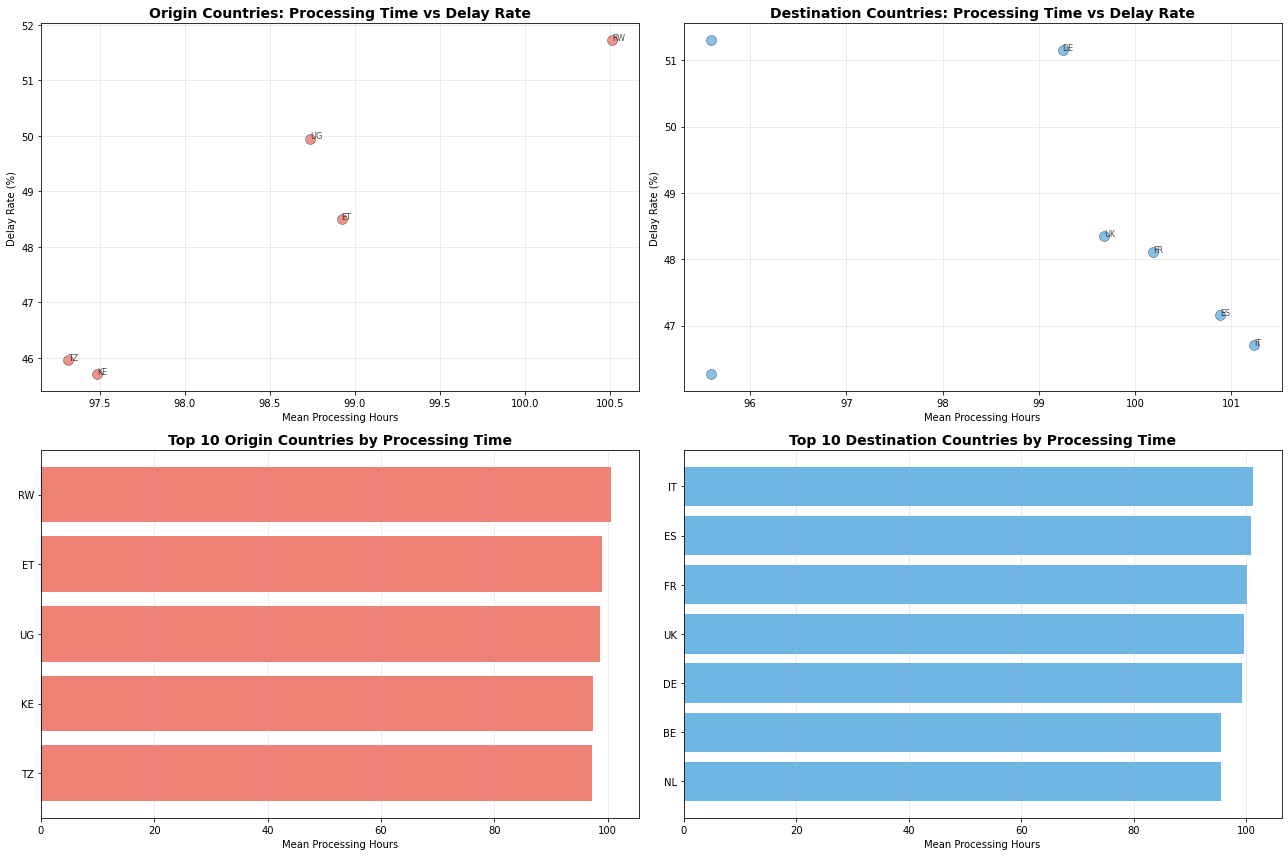


KEY INSIGHTS - Processing Time vs Delay Rate:
--------------------------------------------------------------------------------

Origin Countries with Long Processing but Low Delay Rate (Slow but Reliable):
Empty DataFrame
Columns: [Mean_Processing_Hours, Delay_Rate_Pct]
Index: []


Origin Countries with Fast Processing but High Delay Rate (Fast but Unreliable):
Empty DataFrame
Columns: [Mean_Processing_Hours, Delay_Rate_Pct]
Index: []


In [27]:
# Visualizations comparing processing time vs delay rate
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Origin countries: Processing time vs Delay rate scatter
axes[0, 0].scatter(origin_processing_rank.values, origin_delay_rank[origin_processing_rank.index].values,
                   s=100, alpha=0.6, color='#e74c3c', edgecolors='black', linewidth=0.5)
for country in origin_processing_rank.head(5).index:
    axes[0, 0].annotate(country, 
                       (origin_processing_rank[country], origin_delay_rank[country]),
                       fontsize=8, alpha=0.7)
axes[0, 0].set_xlabel('Mean Processing Hours')
axes[0, 0].set_ylabel('Delay Rate (%)')
axes[0, 0].set_title('Origin Countries: Processing Time vs Delay Rate', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2. Destination countries: Processing time vs Delay rate scatter
axes[0, 1].scatter(dest_processing_rank.values, dest_delay_rank[dest_processing_rank.index].values,
                   s=100, alpha=0.6, color='#3498db', edgecolors='black', linewidth=0.5)
for country in dest_processing_rank.head(5).index:
    axes[0, 1].annotate(country, 
                       (dest_processing_rank[country], dest_delay_rank[country]),
                       fontsize=8, alpha=0.7)
axes[0, 1].set_xlabel('Mean Processing Hours')
axes[0, 1].set_ylabel('Delay Rate (%)')
axes[0, 1].set_title('Destination Countries: Processing Time vs Delay Rate', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Top 10 origin countries by processing time
top_origin_proc = origin_processing_rank.head(10).sort_values(ascending=True)
axes[1, 0].barh(range(len(top_origin_proc)), top_origin_proc.values, 
                color='#e74c3c', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_origin_proc)))
axes[1, 0].set_yticklabels(top_origin_proc.index)
axes[1, 0].set_xlabel('Mean Processing Hours')
axes[1, 0].set_title('Top 10 Origin Countries by Processing Time', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='x')

# 4. Top 10 destination countries by processing time
top_dest_proc = dest_processing_rank.head(10).sort_values(ascending=True)
axes[1, 1].barh(range(len(top_dest_proc)), top_dest_proc.values, 
                color='#3498db', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_dest_proc)))
axes[1, 1].set_yticklabels(top_dest_proc.index)
axes[1, 1].set_xlabel('Mean Processing Hours')
axes[1, 1].set_title('Top 10 Destination Countries by Processing Time', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Identify countries with long processing but low delay rate (and vice versa)
print("\nKEY INSIGHTS - Processing Time vs Delay Rate:")
print("-" * 80)
print("\nOrigin Countries with Long Processing but Low Delay Rate (Slow but Reliable):")
long_low_origin = origin_processing_df[
    (origin_processing_df['Mean_Processing_Hours'] > origin_processing_df['Mean_Processing_Hours'].quantile(0.75)) &
    (origin_processing_df['Delay_Rate_Pct'] < origin_processing_df['Delay_Rate_Pct'].median())
].sort_values('Mean_Processing_Hours', ascending=False)
print(long_low_origin.to_string())

print("\n\nOrigin Countries with Fast Processing but High Delay Rate (Fast but Unreliable):")
fast_high_origin = origin_processing_df[
    (origin_processing_df['Mean_Processing_Hours'] < origin_processing_df['Mean_Processing_Hours'].median()) &
    (origin_processing_df['Delay_Rate_Pct'] > origin_processing_df['Delay_Rate_Pct'].quantile(0.75))
].sort_values('Delay_Rate_Pct', ascending=False)
print(fast_high_origin.to_string())


## 9. Early Red-Flag Analysis (Precursor Signals)


In [28]:
# Analyze doc_completeness_score vs delay rate
df['doc_completeness_bucket'] = pd.cut(df['doc_completeness_score'], 
                                       bins=[0, 0.5, 0.7, 0.9, 1.0], 
                                       labels=['Low (0-0.5)', 'Medium (0.5-0.7)', 
                                               'High (0.7-0.9)', 'Very High (0.9-1.0)'])

doc_completeness_analysis = df.groupby('doc_completeness_bucket').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean'
}).round(2)

doc_completeness_analysis.columns = ['Count', 'Delayed_Count', 'Delay_Rate', 'Avg_Processing_Hours']
doc_completeness_analysis['Delay_Rate_Pct'] = (doc_completeness_analysis['Delay_Rate'] * 100).round(2)

print("=" * 100)
print("DOCUMENT COMPLETENESS SCORE vs DELAY RATE")
print("=" * 100)
print(doc_completeness_analysis.to_string())
print("\n" + "=" * 100)


DOCUMENT COMPLETENESS SCORE vs DELAY RATE
                         Count  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Delay_Rate_Pct
doc_completeness_bucket                                                                        
Low (0-0.5)                  0              0         NaN                   NaN             NaN
Medium (0.5-0.7)             0              0         NaN                   NaN             NaN
High (0.7-0.9)            2097           1316        0.63                106.10            63.0
Very High (0.9-1.0)       2903           1103        0.38                 93.18            38.0



In [29]:
# Analyze doc_amendments vs delay rate
df['amendments_bucket'] = pd.cut(df['doc_amendments'], 
                                 bins=[-1, 0, 1, 2, 10], 
                                 labels=['0', '1', '2', '3+'])

amendments_analysis = df.groupby('amendments_bucket').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean'
}).round(2)

amendments_analysis.columns = ['Count', 'Delayed_Count', 'Delay_Rate', 'Avg_Processing_Hours']
amendments_analysis['Delay_Rate_Pct'] = (amendments_analysis['Delay_Rate'] * 100).round(2)

print("=" * 100)
print("DOCUMENT AMENDMENTS vs DELAY RATE")
print("=" * 100)
print(amendments_analysis.to_string())
print("\n" + "=" * 100)


DOCUMENT AMENDMENTS vs DELAY RATE
                   Count  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Delay_Rate_Pct
amendments_bucket                                                                        
0                   2848           1044        0.37                 92.58            37.0
1                   1584            916        0.58                103.30            58.0
2                    468            366        0.78                113.36            78.0
3+                   100             93        0.93                126.66            93.0



In [30]:
# Analyze congestion_index vs delay rate
df['congestion_bucket'] = pd.cut(df['congestion_index'], 
                                 bins=[0, 0.3, 0.5, 0.7, 1.0], 
                                 labels=['Low (0-0.3)', 'Medium (0.3-0.5)', 
                                         'High (0.5-0.7)', 'Very High (0.7-1.0)'])

congestion_analysis = df.groupby('congestion_bucket').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean'
}).round(2)

congestion_analysis.columns = ['Count', 'Delayed_Count', 'Delay_Rate', 'Avg_Processing_Hours']
congestion_analysis['Delay_Rate_Pct'] = (congestion_analysis['Delay_Rate'] * 100).round(2)

print("=" * 100)
print("CONGESTION INDEX vs DELAY RATE")
print("=" * 100)
print(congestion_analysis.to_string())
print("\n" + "=" * 100)


CONGESTION INDEX vs DELAY RATE
                     Count  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Delay_Rate_Pct
congestion_bucket                                                                          
Low (0-0.3)           1541            403        0.26                 87.17            26.0
Medium (0.3-0.5)      1632            746        0.46                 96.91            46.0
High (0.5-0.7)        1172            761        0.65                106.38            65.0
Very High (0.7-1.0)    654            509        0.78                115.93            78.0



In [31]:
# Analyze weight and value vs processing time
df['weight_bucket'] = pd.qcut(df['gross_weight_kg'], q=4, 
                              labels=['Q1 (Lightest)', 'Q2', 'Q3', 'Q4 (Heaviest)'], 
                              duplicates='drop')
df['value_bucket'] = pd.qcut(df['declared_value_usd'], q=4, 
                             labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'], 
                             duplicates='drop')

weight_analysis = df.groupby('weight_bucket').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean'
}).round(2)

weight_analysis.columns = ['Count', 'Delayed_Count', 'Delay_Rate', 'Avg_Processing_Hours']
weight_analysis['Delay_Rate_Pct'] = (weight_analysis['Delay_Rate'] * 100).round(2)

value_analysis = df.groupby('value_bucket').agg({
    'delayed_flag': ['count', 'sum', 'mean'],
    'total_processing_hours': 'mean'
}).round(2)

value_analysis.columns = ['Count', 'Delayed_Count', 'Delay_Rate', 'Avg_Processing_Hours']
value_analysis['Delay_Rate_Pct'] = (value_analysis['Delay_Rate'] * 100).round(2)

print("=" * 100)
print("WEIGHT vs DELAY RATE")
print("=" * 100)
print(weight_analysis.to_string())

print("\n\nVALUE vs DELAY RATE")
print("=" * 100)
print(value_analysis.to_string())
print("\n" + "=" * 100)


WEIGHT vs DELAY RATE
               Count  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Delay_Rate_Pct
weight_bucket                                                                        
Q1 (Lightest)   1250            577        0.46                 94.92            46.0
Q2              1250            620        0.50                 96.47            50.0
Q3              1250            604        0.48                 96.97            48.0
Q4 (Heaviest)   1250            618        0.49                106.05            49.0


VALUE vs DELAY RATE
              Count  Delayed_Count  Delay_Rate  Avg_Processing_Hours  Delay_Rate_Pct
value_bucket                                                                        
Q1 (Lowest)    1250            602        0.48                 97.24            48.0
Q2             1250            599        0.48                 98.97            48.0
Q3             1250            585        0.47                 98.26            47.0
Q4 (Highest)   1

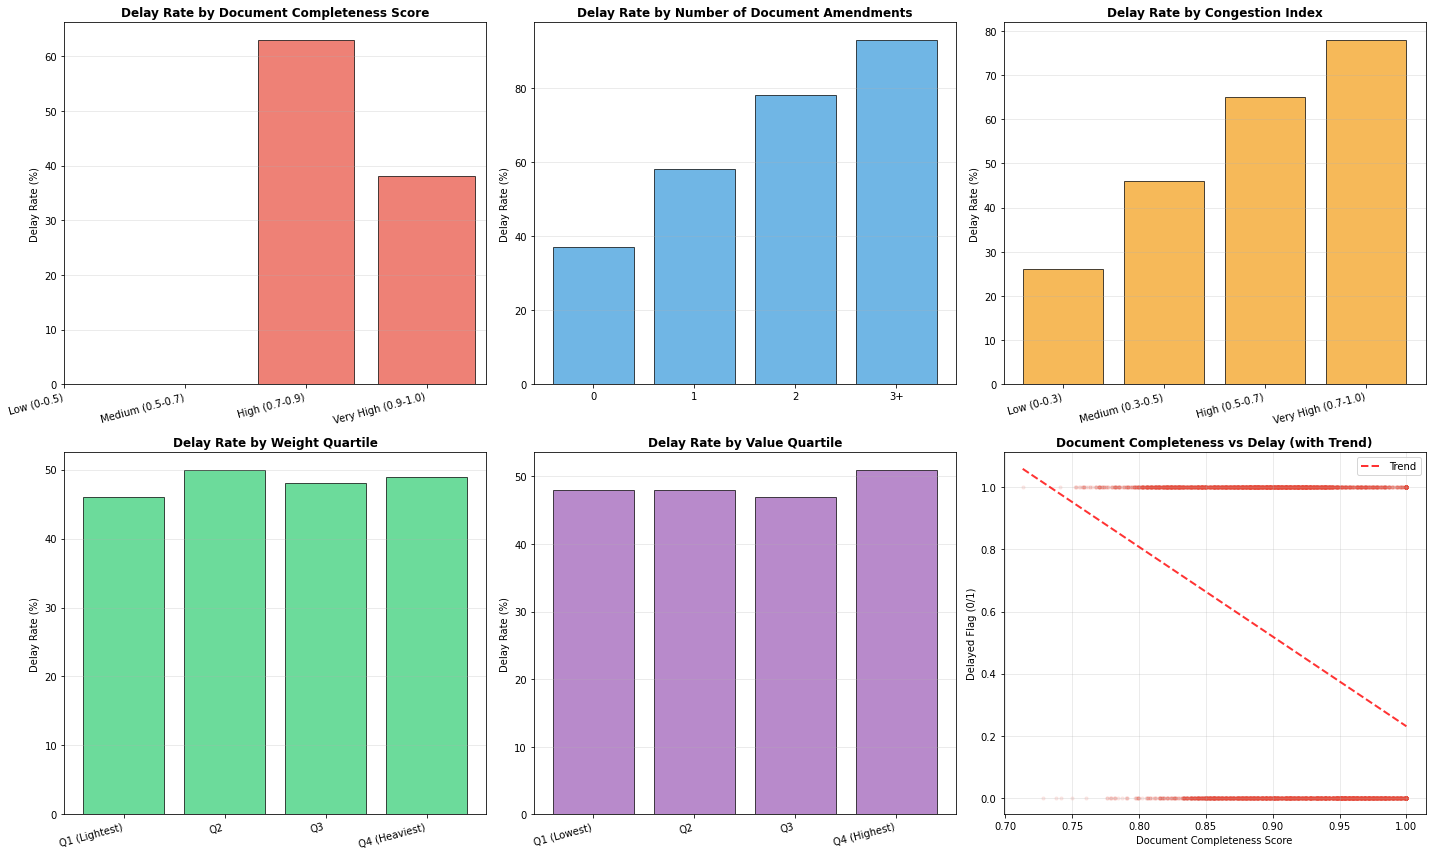


CORRELATION ANALYSIS - Early Red Flags:
--------------------------------------------------------------------------------
doc_completeness_score vs delayed_flag: -0.3361
doc_amendments vs delayed_flag: 0.3012
congestion_index vs delayed_flag: 0.3793
gross_weight_kg vs total_processing_hours: 0.1452
declared_value_usd vs total_processing_hours: 0.0355


In [32]:
# Visualizations for early red-flag analysis
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Document completeness vs delay rate
axes[0, 0].bar(range(len(doc_completeness_analysis)), doc_completeness_analysis['Delay_Rate_Pct'], 
               color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 0].set_xticks(range(len(doc_completeness_analysis)))
axes[0, 0].set_xticklabels(doc_completeness_analysis.index, rotation=15, ha='right')
axes[0, 0].set_ylabel('Delay Rate (%)')
axes[0, 0].set_title('Delay Rate by Document Completeness Score', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Document amendments vs delay rate
axes[0, 1].bar(range(len(amendments_analysis)), amendments_analysis['Delay_Rate_Pct'], 
               color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(len(amendments_analysis)))
axes[0, 1].set_xticklabels(amendments_analysis.index)
axes[0, 1].set_ylabel('Delay Rate (%)')
axes[0, 1].set_title('Delay Rate by Number of Document Amendments', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Congestion index vs delay rate
axes[0, 2].bar(range(len(congestion_analysis)), congestion_analysis['Delay_Rate_Pct'], 
               color='#f39c12', alpha=0.7, edgecolor='black')
axes[0, 2].set_xticks(range(len(congestion_analysis)))
axes[0, 2].set_xticklabels(congestion_analysis.index, rotation=15, ha='right')
axes[0, 2].set_ylabel('Delay Rate (%)')
axes[0, 2].set_title('Delay Rate by Congestion Index', fontsize=12, fontweight='bold')
axes[0, 2].grid(alpha=0.3, axis='y')

# 4. Weight vs delay rate
axes[1, 0].bar(range(len(weight_analysis)), weight_analysis['Delay_Rate_Pct'], 
               color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(len(weight_analysis)))
axes[1, 0].set_xticklabels(weight_analysis.index, rotation=15, ha='right')
axes[1, 0].set_ylabel('Delay Rate (%)')
axes[1, 0].set_title('Delay Rate by Weight Quartile', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 5. Value vs delay rate
axes[1, 1].bar(range(len(value_analysis)), value_analysis['Delay_Rate_Pct'], 
               color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 1].set_xticks(range(len(value_analysis)))
axes[1, 1].set_xticklabels(value_analysis.index, rotation=15, ha='right')
axes[1, 1].set_ylabel('Delay Rate (%)')
axes[1, 1].set_title('Delay Rate by Value Quartile', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3, axis='y')

# 6. Scatter: doc_completeness_score vs delay_flag
axes[1, 2].scatter(df['doc_completeness_score'], df['delayed_flag'], 
                   alpha=0.1, s=10, color='#e74c3c')
# Add trend line
z = np.polyfit(df['doc_completeness_score'], df['delayed_flag'], 1)
p = np.poly1d(z)
axes[1, 2].plot(df['doc_completeness_score'].sort_values(), 
                p(df['doc_completeness_score'].sort_values()), 
                "r--", alpha=0.8, linewidth=2, label='Trend')
axes[1, 2].set_xlabel('Document Completeness Score')
axes[1, 2].set_ylabel('Delayed Flag (0/1)')
axes[1, 2].set_title('Document Completeness vs Delay (with Trend)', fontsize=12, fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
print("\nCORRELATION ANALYSIS - Early Red Flags:")
print("-" * 80)
print(f"doc_completeness_score vs delayed_flag: {df['doc_completeness_score'].corr(df['delayed_flag']):.4f}")
print(f"doc_amendments vs delayed_flag: {df['doc_amendments'].corr(df['delayed_flag']):.4f}")
print(f"congestion_index vs delayed_flag: {df['congestion_index'].corr(df['delayed_flag']):.4f}")
print(f"gross_weight_kg vs total_processing_hours: {df['gross_weight_kg'].corr(df['total_processing_hours']):.4f}")
print(f"declared_value_usd vs total_processing_hours: {df['declared_value_usd'].corr(df['total_processing_hours']):.4f}")


## 10. Key Insights Summary


In [33]:
# Generate comprehensive insights summary
print("=" * 100)
print("DESCRIPTIVE ANALYTICS - KEY INSIGHTS SUMMARY")
print("=" * 100)

print("\n1. OVERALL DELAY LANDSCAPE:")
print(f"   • Overall delay rate: {delay_rate:.2f}%")
print(f"   • Mean processing time: {df['total_processing_hours'].mean():.2f} hours")
print(f"   • Median processing time: {df['total_processing_hours'].median():.2f} hours")
print(f"   • P90 processing time: {df['total_processing_hours'].quantile(0.90):.2f} hours")
if len(delayed_df) > 0:
    print(f"   • Mean delay hours (for delayed): {delayed_df['delay_hours'].mean():.2f} hours")

print("\n2. ORIGIN COUNTRY INSIGHTS:")
top_origin = origin_analysis.head(3)
print(f"   • Top 3 origin countries by delay rate:")
for idx, (country, row) in enumerate(top_origin.iterrows(), 1):
    print(f"     {idx}. {country}: {row['Delay_Rate_Pct']:.2f}% delay rate, "
          f"{row['Avg_Processing_Hours']:.2f}h avg processing")

print("\n3. DESTINATION COUNTRY INSIGHTS:")
top_dest = dest_analysis.head(3)
print(f"   • Top 3 destination countries by delay rate:")
for idx, (country, row) in enumerate(top_dest.iterrows(), 1):
    print(f"     {idx}. {country}: {row['Delay_Rate_Pct']:.2f}% delay rate, "
          f"{row['Avg_Processing_Hours']:.2f}h avg processing")

print("\n4. TIME-BASED INSIGHTS:")
print(f"   • Night consignments delay rate: {night_df['delayed_flag'].mean()*100:.2f}%")
print(f"   • Day consignments delay rate: {day_df['delayed_flag'].mean()*100:.2f}%")
print(f"   • Weekend created delay rate: {weekend_delay:.2f}%")
print(f"   • Weekday created delay rate: {weekday_delay:.2f}%")

print("\n5. COMMODITY INSIGHTS:")
top_commodity = commodity_analysis.head(3)
print(f"   • Top 3 commodities by delay rate:")
for idx, (commodity, row) in enumerate(top_commodity.iterrows(), 1):
    print(f"     {idx}. {commodity}: {row['Delay_Rate_Pct']:.2f}% delay rate")

print("\n6. EARLY RED-FLAG INSIGHTS:")
print(f"   • Document completeness correlation: {df['doc_completeness_score'].corr(df['delayed_flag']):.4f}")
print(f"   • Document amendments correlation: {df['doc_amendments'].corr(df['delayed_flag']):.4f}")
print(f"   • Congestion index correlation: {df['congestion_index'].corr(df['delayed_flag']):.4f}")

print("\n7. PORT PERFORMANCE INSIGHTS:")
print(f"   • Origin ports analyzed: {len(origin_port_analysis)}")
print(f"   • Destination ports analyzed: {len(dest_port_analysis)}")
top_origin_port = origin_port_analysis.head(1)
if len(top_origin_port) > 0:
    port_name = top_origin_port.index[0]
    print(f"   • Highest delay rate origin port: {port_name} "
          f"({top_origin_port.loc[port_name, 'Delay_Rate_Pct']:.2f}%)")

print("\n" + "=" * 100)
print("END OF DESCRIPTIVE ANALYTICS")
print("=" * 100)


DESCRIPTIVE ANALYTICS - KEY INSIGHTS SUMMARY

1. OVERALL DELAY LANDSCAPE:
   • Overall delay rate: 48.38%
   • Mean processing time: 98.60 hours
   • Median processing time: 96.80 hours
   • P90 processing time: 145.56 hours
   • Mean delay hours (for delayed): 17.65 hours

2. ORIGIN COUNTRY INSIGHTS:
   • Top 3 origin countries by delay rate:
     1. RW: 52.00% delay rate, 100.51h avg processing
     2. UG: 50.00% delay rate, 98.74h avg processing
     3. ET: 48.00% delay rate, 98.92h avg processing

3. DESTINATION COUNTRY INSIGHTS:
   • Top 3 destination countries by delay rate:
     1. BE: 51.00% delay rate, 95.60h avg processing
     2. DE: 51.00% delay rate, 99.25h avg processing
     3. FR: 48.00% delay rate, 100.18h avg processing

4. TIME-BASED INSIGHTS:
   • Night consignments delay rate: 50.04%
   • Day consignments delay rate: 47.84%
   • Weekend created delay rate: 69.09%
   • Weekday created delay rate: 40.40%

5. COMMODITY INSIGHTS:
   • Top 3 commodities by delay rate:
 

In [34]:
# -----------------------------
# DEFINE FEATURES AND TARGET
# -----------------------------
# These are EARLY-WARNING features available before clearance is completed

baseline_features = [
    'shipment_mode',           # Air / Sea / Road etc.
    'commodity',               # Type of horticultural product
    'hs_code',                 # Harmonized System code
    'origin_country',          # Exporting country
    'destination_country',     # Importing country
    'exporter_profile',        # Exporter risk/profile category
    'doc_completeness_score',  # Quality/completeness of documentation
    'missing_docs_proxy',      # Indicator/count of missing documents
    'doc_amendments',          # Number of document corrections
    'congestion_index',        # System-level congestion indicator
    'is_weekend_created',      # Whether shipment was created on weekend
    'gross_weight_kg',         # Shipment weight
    'declared_value_usd'       # Declared customs value
]

# Assign X = predictors, y = target
X = df[baseline_features]
y = df['delayed_flag']  # 1 = delayed, 0 = not delayed

# -----------------------------
# GROUP FEATURES BY TYPE
# -----------------------------
# This allows correct preprocessing for each feature category

categorical_features = [
    'shipment_mode', 'commodity', 'hs_code',
    'origin_country', 'destination_country', 'exporter_profile'
]

numeric_features = [
    'doc_completeness_score', 'missing_docs_proxy', 'doc_amendments',
    'congestion_index', 'gross_weight_kg', 'declared_value_usd'
]

binary_features = ['is_weekend_created']

# -----------------------------
# TRAIN–TEST SPLIT
# -----------------------------
# Stratification ensures the delay/non-delay ratio is preserved

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,        # 80% train, 20% test
    stratify=y,           # Preserve class balance
    random_state=42
)

# -----------------------------
# PREPROCESSING PIPELINE
# -----------------------------
# - Categorical features: One-hot encoding
# - Numeric features: Standard scaling
# - Binary features: Passed through unchanged

preprocessor = ColumnTransformer(
    transformers=[
        (
            'cat',
            OneHotEncoder(
                handle_unknown='ignore',  # Handle unseen categories safely
                min_frequency=0.01         # Reduce high-cardinality noise (e.g. HS codes)
            ),
            categorical_features
        ),
        (
            'num',
            StandardScaler(),             # Normalize numeric ranges
            numeric_features
        ),
        (
            'bin',
            'passthrough',                # Binary feature needs no transformation
            binary_features
        )
    ]
)

In [35]:
# ================================
# BASELINE MODEL: LOGISTIC REGRESSION
# ================================
# Purpose:
# - Establish a transparent, interpretable baseline
# - Understand direction and strength of predictors

log_reg_pipeline = Pipeline(steps=[
('preprocessor', preprocessor),
(
'classifier',
LogisticRegression(
max_iter=1000, # Ensure convergence
class_weight='balanced', # Handle class imbalance
n_jobs=-1
)
)
])

# Train the model
log_reg_pipeline.fit(X_train, y_train)


# Generate predictions and probabilities
y_pred_lr = log_reg_pipeline.predict(X_test)
y_prob_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]


# Evaluate performance
print("Logistic Regression – Baseline Features")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression – Baseline Features
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       516
           1       0.81      0.80      0.81       484

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

ROC-AUC: 0.8976551989236978


In [36]:
# ================================
# XGBOOST MODEL: BASELINE FEATURES
# ================================
# Purpose:
# - Gradient boosting model for improved performance
# - Uses same baseline features as logistic regression

# Transform the data using the preprocessor
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# Train the model
xgb_model.fit(X_train_transformed, y_train)

# Generate predictions and probabilities
y_pred_xgb = xgb_model.predict(X_test_transformed)
y_prob_xgb = xgb_model.predict_proba(X_test_transformed)[:, 1]

# Evaluate performance
print("XGBoost – Baseline Features")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("\n" + "="*80 + "\n")

# ================================
# LIGHTGBM MODEL: BASELINE FEATURES
# ================================
# Purpose:
# - Light gradient boosting model for fast training
# - Uses same baseline features as logistic regression

# LightGBM model
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

# Train the model
lgb_model.fit(X_train_transformed, y_train)

# Generate predictions and probabilities
y_pred_lgb = lgb_model.predict(X_test_transformed)
y_prob_lgb = lgb_model.predict_proba(X_test_transformed)[:, 1]

# Evaluate performance
print("LightGBM – Baseline Features")
print(classification_report(y_test, y_pred_lgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lgb))

[00:14:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost – Baseline Features
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       516
           1       0.80      0.79      0.79       484

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000

ROC-AUC: 0.8846819142802229


LightGBM – Baseline Features
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       516
           1       0.80      0.76      0.78       484

    accuracy               

### RANDOM FOREST ###

In [37]:
#Import libraries
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve


In [38]:
#Define the features and the target

X = df[baseline_features]
y = df['delayed_flag']

In [39]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [40]:
#Preprocessing
preprocessor = ColumnTransformer(transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01), categorical_features),
            ('num', StandardScaler(), numeric_features),
            ('bin', 'passthrough', binary_features)
])

In [41]:
# Random forest pipeline
clf = Pipeline([('preprocessor', preprocessor),
                   ('model', RandomForestClassifier(n_estimators = 200,
                                                  max_depth = None,
                                                  random_state=42,
                                                  class_weight = 'balanced'))])

#This ensures prerocessing is applied consistently to train and test sets

In [42]:
#Training of the Random forest model
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                min_frequency=0.01),
                                                  ['shipment_mode', 'commodity',
                                                   'hs_code', 'origin_country',
                                                   'destination_country',
                                                   'exporter_profile']),
                                                 ('num', StandardScaler(),
                                                  ['doc_completeness_score',
                                                   'missing_docs_proxy',
                                                   'doc_amendments',
                                                   'congestion_index',
                                                   'gross_weight_kg',
                                                   'declared_value_usd']),
                                                 ('bin', 'passthrough',
                                                  ['is_weekend_created'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [43]:
#Evaluation of the Random Forest model

y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.799

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       516
           1       0.80      0.78      0.79       484

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



Accuracy 0.799(~0.8) means the model correctly predicted whether a shipment was delayed in 8 out of ten cases on the test set.

The model perfomed well for both the delayed and non-delayed shipments.

Non-delayed shipment had a higher recall meaning the model captured this shipments better than the delayed ones.

The model is not biased as bothe precision and recall is balanced on both classes


#### Visualizations ###


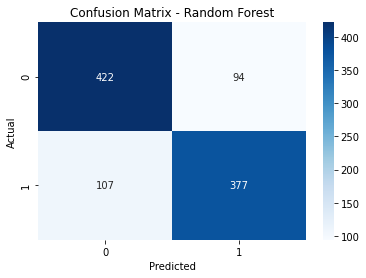

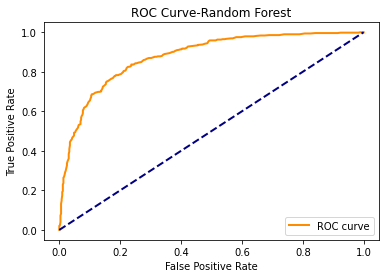

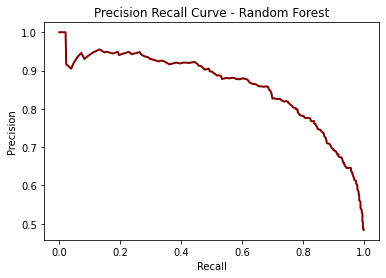

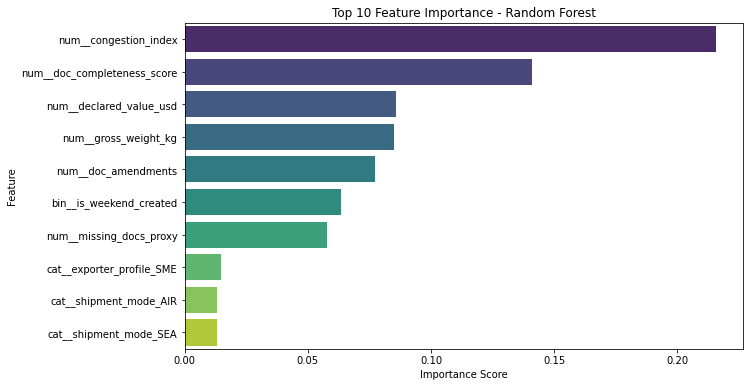

In [44]:

#--------- Confusion Matrix ---------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# ------- ROC Curve -------
y_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc (fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle = '--')
plt.title('ROC Curve-Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# ------Precision Recall Curve -----
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, color = 'maroon', lw=2)
plt.title('Precision Recall Curve - Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()



# ------Feature Importance -----

#extract rf from the pipeline
rf_model = clf.named_steps['model']

#Feature importances
importances = rf_model.feature_importances_

#feature names after preprocessing
feature_names = clf.named_steps['preprocessor'].get_feature_names_out()

#create DataFrame
feat_importances = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
}).sort_values(by='Importance', ascending=False)

#plot top 10 features
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importances.head(10), palette='viridis')
plt.title('Top 10 Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


The confusion matrix gives a view on misclassifications

The ROC curve shows how the model can discriminate between the two classes

Precision curve shows trade-off between catching delays vs avoiding false alarms

Random forest gives feature importance scores that help in understanding which logistic factors drive delays
